# IRD Xenium Spatial Neighborhood Analysis

This notebook performs downstream analysis of Xenium spatial transcriptomics data from the Multiple Myeloma IRD study. The study focuses on understanding the microenvironment changes in newly diagnosed multiple myeloma (NDMM) and after autologous stem cell transplant (ASCT) therapy. The analysis includes cell type composition, gene expression patterns, immune microenvironment characterization, and spatial neighborhood identification.

Data preprocessing and cell type annotation were performed outside of this notebook.


In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from itertools import combinations

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
# Import custom helper functions
import sys
sys.path.append('/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils')
import spatial_utils
import plot_utils

# If helper functions are updated, uncomment and run this line
#import importlib
#importlib.reload(plot_utils)

## Section 1: Data Loading and Cell Type Composition

Load the merged Xenium spatial transcriptomics dataset and analyze cell type composition across different collection timepoints (NBM, NDMM, PT).

### Load merged Xenium data and revised cell type annotations

The merged dataset contains cells from multiple samples across three collection timepoints:
- **NBM**: Normal bone marrow
- **NDMM**: Newly diagnosed multiple myeloma
- **PT**: Post-treatment

In [3]:
ird_xenium_merge = sc.read_h5ad("/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/merged.h5ad")
ird_xenium_merge.obs.head()

,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,DI_Sample,Collection,Panel,MRD.Status,Months_PFS,nCounts,annot,clust,ct,Original_Barcode
IRD_S18-30740A1U3_aaaefkpp-1,433.430206,1357.545288,37.660314,23.932813,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,136.0,Erythro,Erythroid,Erythroid,aaaefkpp-1
IRD_S18-30740A1U3_aaaekejm-1,449.853851,1278.230225,31.067501,20.817032,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,115.0,Granulo,Late Myeloid,Late Myeloid,aaaekejm-1
IRD_S18-30740A1U3_aaaekekb-1,438.366547,1361.509277,46.240002,17.340001,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,137.0,Erythro,NK_T,NK,aaaekekb-1
IRD_S18-30740A1U3_aaaeonma-1,438.007660,1311.078979,125.715005,59.380471,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,291.0,Erythro,Erythroid,Erythroid,aaaeonma-1
IRD_S18-30740A1U3_aaaflkno-1,373.216797,1557.585327,46.194845,30.480470,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,88.0,Erythro,Erythroid,Erythroid,aaaflkno-1


In [4]:
# The most updated cell type annotation is in the 'ct' column
ird_xenium_merge.obs['ct'].unique().tolist()

['Erythroid',
 'Late Myeloid',
 'NK',
 'PC',
 'Mature B',
 'CD8 T',
 'Monocyte',
 'Low Confidence',
 'CD4 T',
 'GMP',
 'Neutrophil',
 'Early B',
 'Adipocyte',
 'Megakaryocyte',
 'HSPC',
 'Macrophage',
 'Fibro/Osteo',
 'MSC',
 'Endothelial',
 'pDC',
 'Ba/Eo/Ma',
 'cDC',
 'vSMC/Pericyte']

### Cell type composition analysis across timepoints

Calculate the percentage of cell types per sample and compare across collection timepoints to identify disease-associated changes in cell type abundance.


In [4]:
# Calculate percentage of each cell type in each sample
ird_cell_info = ird_xenium_merge.obs.copy()
ct_counts = ird_cell_info.groupby(['Sample', 'ct']).size().reset_index(name = 'ct_count')   ## Number of cells per cell type per sample
sample_counts = ird_cell_info.groupby('Sample').size().reset_index(name='total_count')        ## Total number of cells per sample
ct_counts = ct_counts.merge(sample_counts, on='Sample', how='left')
ct_counts['pct'] = ct_counts['ct_count'] / ct_counts['total_count'] * 100
ct_counts = ct_counts.merge(ird_cell_info[['Sample', 'Collection']].drop_duplicates(), on='Sample', how='left')
ct_counts.head()


/diskmnt/Users2/chouw/temp/ipykernel_66377/804087989.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct_counts = ird_cell_info.groupby(['Sample', 'ct']).size().reset_index(name = 'ct_count')   ## Number of cells per cell type per sample
/diskmnt/Users2/chouw/temp/ipykernel_66377/804087989.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_counts = ird_cell_info.groupby('Sample').size().reset_index(name='total_count')        ## Total number of cells per sample


,Sample,ct,ct_count,total_count,pct,Collection
0,IRD_S18-30740A1U3,HSPC,38,92573,0.041049,NDMM
1,IRD_S18-30740A1U3,Erythroid,17009,92573,18.373608,NDMM
2,IRD_S18-30740A1U3,Megakaryocyte,691,92573,0.746438,NDMM
3,IRD_S18-30740A1U3,GMP,4386,92573,4.737883,NDMM
4,IRD_S18-30740A1U3,Late Myeloid,6763,92573,7.305586,NDMM


/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_y_by_group = df.groupby(x_col)[y_col].max().to_dict()


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'HSPC'),
  Text(1, 0, 'Erythroid'),
  Text(2, 0, 'Megakaryocyte'),
  Text(3, 0, 'GMP'),
  Text(4, 0, 'Late Myeloid'),
  Text(5, 0, 'Neutrophil'),
  Text(6, 0, 'Ba/Eo/Ma'),
  Text(7, 0, 'cDC'),
  Text(8, 0, 'Monocyte'),
  Text(9, 0, 'Macrophage'),
  Text(10, 0, 'pDC'),
  Text(11, 0, 'CD4 T'),
  Text(12, 0, 'CD8 T'),
  Text(13, 0, 'NK'),
  Text(14, 0, 'Early B'),
  Text(15, 0, 'Mature B'),
  Text(16, 0, 'PC'),
  Text(17, 0, 'MSC'),
  Text(18, 0, 'Fibro/Osteo'),
  Text(19, 0, 'Adipocyte'),
  Text(20, 0, 'Endothelial'),
  Text(21, 0, 'vSMC/Pericyte'),
  Text(22, 0, 'Low Confidence')])

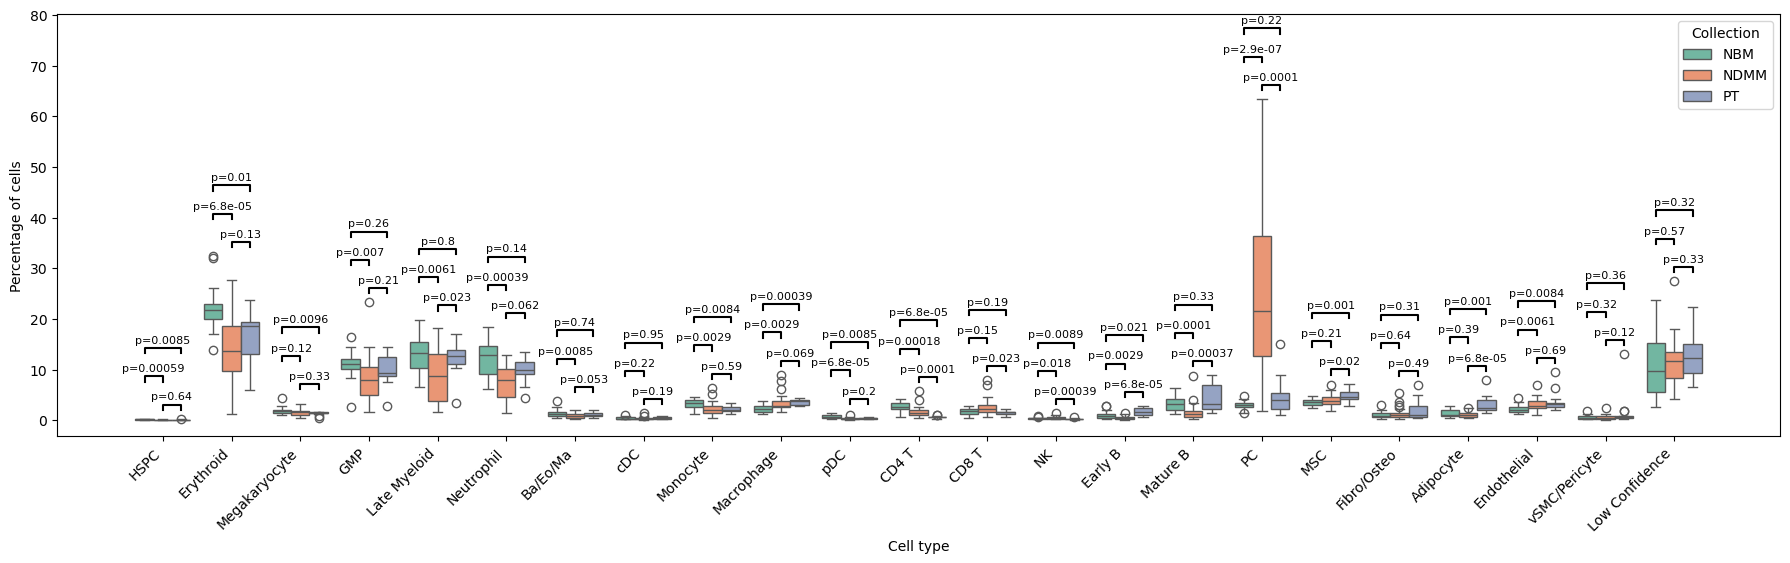

In [5]:
_ = plot_utils.plot_multigroup_boxplot_with_significance(ct_counts, 'ct', 'pct', 'Collection', show_swarm = False,
                                                    palette = 'Set2', figsize=(18, 5), xlabel='Cell type', ylabel='Percentage of cells', title=None, save_path=None) 
plt.xticks(rotation=45, ha='right')

### Observations
- Immune Compartment
    - Plasma cells take over the bone marrow in NDMM and revert to normal ranges after treatment. 
    - In compensation, erythroid, GMP, late myeloid, neutrophils proportions decreased in NDMM. In normal bone marrow, these cells account for 60-70% of the bone marrow.
    - B cells and their progenitors decreased in proportion in NDMM, but were restored after stem cell transplant in PT.
    - Macrophages increased in proportions in NDMM and were further increased in PT. Monocytes, on the other hand, decreased in proportions from normal bone marrow.
    - CD4 T cells drastically decreased in proportions in NDMM and is further depleted in PT. CD8 T cells and NK cells show a higher proportion in NDMM and slightly decreased in PT.
- Stromal Compartment
    - Overall increased in proportions in NDMM and PT, including MSCs, endothelial eclls, and adipocytes

These observations give rise to a few biological hypotheses, which will be tested in the following sections

1. Plasma cells out-compete B cells and their progenitors for survival signals, leading to their proliferation and inhibits the normal B-to-PC transformation. This is restored post stem cell transplant.
    - These signals may include APRIL/BAFF signaling from myeloid cells and CXCL signaling from stromal cells (MSCs).
2. The post-transplant immune microenvironment are still dysfunctional, such as the elevated macrophage proportions and decreased CD4 T cells.
    - These macrophages may still exhibit immunosuppressive capabilities that induces T cell exhaustion.

## Section 2: APRIL/BAFF signaling between myeloid and B cells/plasma cells

APRIL pathway: Myeloid cells expressing TNFSF13 (APRIL) and plasma cells expressing TNFRSF17 (BCMA), TNFRSF13B (TACI)

BAFF pathway: Myeloid cells expressing TNFSF13B (BAFF) and plasma cells expressing TNFRSF13B (TACI), TNFRSF13C (BAFF-R)

**Note**: Many of these genes are only present in the v6 custom panel.

### Expression of APRIL/BAFF receptor/ligands across cell types and timepoints

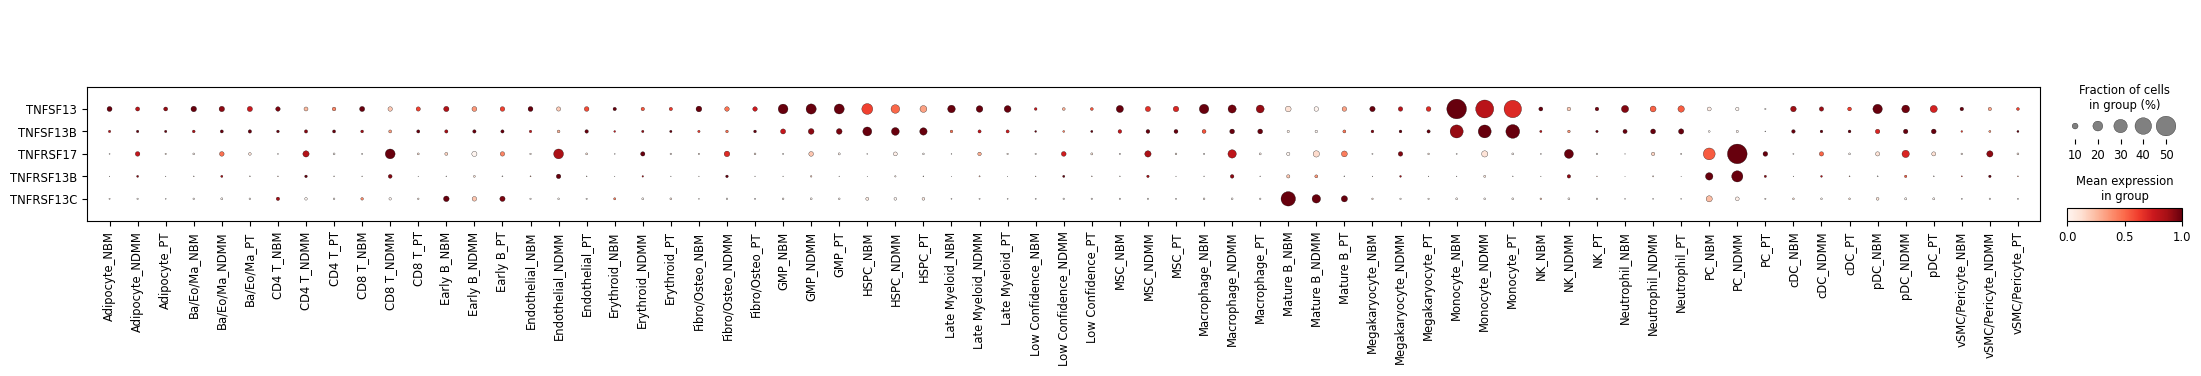

In [6]:
ird_v6 = ird_xenium_merge[ird_xenium_merge.obs['Panel'] == 'BYGXJ6_hMulti', :].copy()
ird_v6.obs['ct_timepoint'] = ird_v6.obs.apply(lambda x: f"{x['ct']}_{x['Collection']}", axis = 1)
sc.pl.dotplot(ird_v6, var_names = ['TNFSF13', 'TNFSF13B', 'TNFRSF17', 'TNFRSF13B', 'TNFRSF13C'], groupby = 'ct_timepoint', standard_scale = 'var', dot_max = 0.5, cmap = 'Reds', swap_axes = True)

Observations:
- APRIL expression is highest on monocytes, but also present on GMP/Late myeloid/neutrophil/pDCs. APRIL expression decrease in NDMM and increase in PT.
- BCMA/TACI expression on plasma cells increase in NDMM and decrease in PT. They are also seen to be expressed in all other cell types in NDMM, most likely due to transcript leakage.
- BAFF expression is also highest on monocytes, but the expression is not as high on GMP/Late myeloid/neutrophils. Interestingly there is some expression on HSPCs. BAFF seems to increase during PT.
- BAFF-R is expressed in Mature B cells and at lower levels on early B cells.

Hypothesis:
**Plasma cells in NDMM hijacks the survival APRIL/BAFF signaling for early/mature B cells**

To test this hypothesis, we wanted to know:
- Are plasma cells closer to APRIL+/BAFF+ cells in NDMM?

### Distance between (APRIL+) myeloid cells and (BCMA+) plasma cells

In [7]:
## Load Julia's radial neighborhood object
rn_obj = sc.read_h5ad("/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/radial_neighborhoods/Output/merged_RN.h5ad")
ird_v6 = rn_obj[rn_obj.obs['Panel'] == 'BYGXJ6_hMulti'].copy()

In [8]:
## Filter out cells with unassigned radial neighborhood -> these are cells in low density regions
ird_v6 = ird_v6[ird_v6.obs['rn'] != 'Unassigned']

In [9]:
april_df = ird_v6[:, 'TNFSF13'].to_df()
baff_df = ird_v6[:, 'TNFSF13B'].to_df()
ird_v6.obs.loc[:, 'APRILpos'] = april_df['TNFSF13'] > 0
ird_v6.obs.loc[:, 'APRIL_exp'] = april_df['TNFSF13'].values
ird_v6.obs.loc[:, 'BAFFpos'] = baff_df['TNFSF13B'] > 0

april_ligand_df = ird_v6[:, ['TNFRSF17', 'TNFRSF13B']].to_df()
baff_ligand_df = ird_v6[:, ['TNFRSF13B', 'TNFRSF13C']].to_df()
ird_v6.obs.loc[:, 'APRIL_receptor_pos'] = (april_ligand_df['TNFRSF17'] > 0) | (april_ligand_df['TNFRSF13B'] > 0)
ird_v6.obs.loc[:, 'BAFF_receptor_pos'] = (baff_ligand_df['TNFRSF13B'] > 0) | (baff_ligand_df['TNFRSF13C'] > 0)


/diskmnt/Users2/chouw/Software/miniforge3/envs/scanpy/lib/python3.11/site-packages/pandas/core/indexing.py:1858: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.obj[key] = value


In [10]:
ird_cells_info = ird_v6.obs.copy()

#### Nearest distance between all myeloid cells to all PC/B cells

Since the detection of genes by Xenium probes can be sparse, we first consider all myeloid cells to be the source of APRIL expression and plasma cell/B cell as the source of APRIL receptor (BCMA/TACI) expression.

In [13]:
myeloid_pos = ird_cells_info[ird_cells_info['ct'].isin(['GMP', 'Late Myeloid', 'Neutrophil', 'Monocyte', 'Macrophage','cDC', 'pDC'])][['Sample', 'x_centroid', 'y_centroid']]
plasma_pos = ird_cells_info[ird_cells_info['ct'] == 'PC'][['Sample', 'x_centroid', 'y_centroid']]
b_pos = ird_cells_info[ird_cells_info['ct'] == 'Mature B'][['Sample', 'x_centroid', 'y_centroid']]
earlyb_pos = ird_cells_info[ird_cells_info['ct'] == 'Early B'][['Sample', 'x_centroid', 'y_centroid']]
mye_pc_dist = spatial_utils.nearest_dist_between_two_celltypes(myeloid_pos, plasma_pos, sample_col='Sample', x_col='x_centroid', y_col='y_centroid')
mye_b_dist = spatial_utils.nearest_dist_between_two_celltypes(myeloid_pos, b_pos, sample_col='Sample', x_col='x_centroid', y_col='y_centroid')
mye_earlyb_dist = spatial_utils.nearest_dist_between_two_celltypes(myeloid_pos, earlyb_pos, sample_col='Sample', x_col='x_centroid', y_col='y_centroid')

In [14]:
mye_pc_dist['ref_ct'] = 'Plasma cell'
mye_b_dist['ref_ct'] = 'Mature B cell'
mye_earlyb_dist['ref_ct'] = 'Early B cell'
mye_dist = pd.concat([mye_pc_dist, mye_b_dist, mye_earlyb_dist], axis = 0)

In [15]:
# To get sample-level statistic, we can use the mode of the distance distribution to represent the most likely distance between myeloid and PC/B cells
# To get the most likely distance, we fit the distance distribution to a Gaussian KDE and use the mode of the distribution
from scipy.stats import gaussian_kde

res = []
for sample in mye_dist['Sample'].unique():
    sample_df = mye_dist[mye_pc_dist['Sample'] == sample]
    for ref_ct in sample_df['ref_ct'].unique():
        sample_ref_df = sample_df[sample_df['ref_ct'] == ref_ct]
        if len(sample_ref_df) < 10:
            continue
        # Estimate distance using KDE
        kde = gaussian_kde(sample_ref_df['nearest_dist_to_df2'])
        dist_eval = np.arange(0, 501, 1)
        kde_pdf = kde.pdf(dist_eval)
        most_likely_dist = dist_eval[np.argmax(kde_pdf)]
        res.append({
            'Sample': sample,
            'Reference Cell Type': ref_ct,
            'Most Likely Distance': most_likely_dist,
            'Average Distance': sample_ref_df['nearest_dist_to_df2'].mean(),
            'Median Distance': sample_ref_df['nearest_dist_to_df2'].median()
        })

most_likely_dists_df = pd.DataFrame(res)


/diskmnt/Users2/chouw/temp/ipykernel_66377/246327185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = mye_dist[mye_pc_dist['Sample'] == sample]
/diskmnt/Users2/chouw/temp/ipykernel_66377/246327185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = mye_dist[mye_pc_dist['Sample'] == sample]
/diskmnt/Users2/chouw/temp/ipykernel_66377/246327185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = mye_dist[mye_pc_dist['Sample'] == sample]
/diskmnt/Users2/chouw/temp/ipykernel_66377/246327185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = mye_dist[mye_pc_dist['Sample'] == sample]
/diskmnt/Users2/chouw/temp/ipykernel_66377/246327185.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_df = mye_dist[mye_pc_dist['Sample'] == sample]
/diskmnt/Users2/chouw/temp/ipykernel_66377/24

In [16]:
# Add collection information
metadata = ird_cells_info[['Sample', 'Collection']].drop_duplicates().set_index('Sample')
most_likely_dists_df['Collection'] = most_likely_dists_df['Sample'].map(metadata['Collection'])
most_likely_dists_df.head()

,Sample,Reference Cell Type,Most Likely Distance,Average Distance,Median Distance,Collection
0,S11-3564A1U1,Plasma cell,11,24.217855,12.311941,NDMM
1,S11-3564A1U1,Mature B cell,22,43.244166,29.743266,NDMM
2,S11-3564A1U1,Early B cell,43,86.047661,64.512411,NDMM
3,S13-35096A1U1,Plasma cell,8,17.868871,13.634731,NDMM
4,S13-35096A1U1,Mature B cell,22,46.899337,38.191697,NDMM


/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:153: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(df, x = x_col, y = y_col, hue = hue_col, order=order, hue_order=hue_order, dodge = True, color = 'k', alpha = 0.5, size = 3.5)


([0, 1, 2],
 [Text(0, 0, 'Plasma cell'),
  Text(1, 0, 'Mature B cell'),
  Text(2, 0, 'Early B cell')])

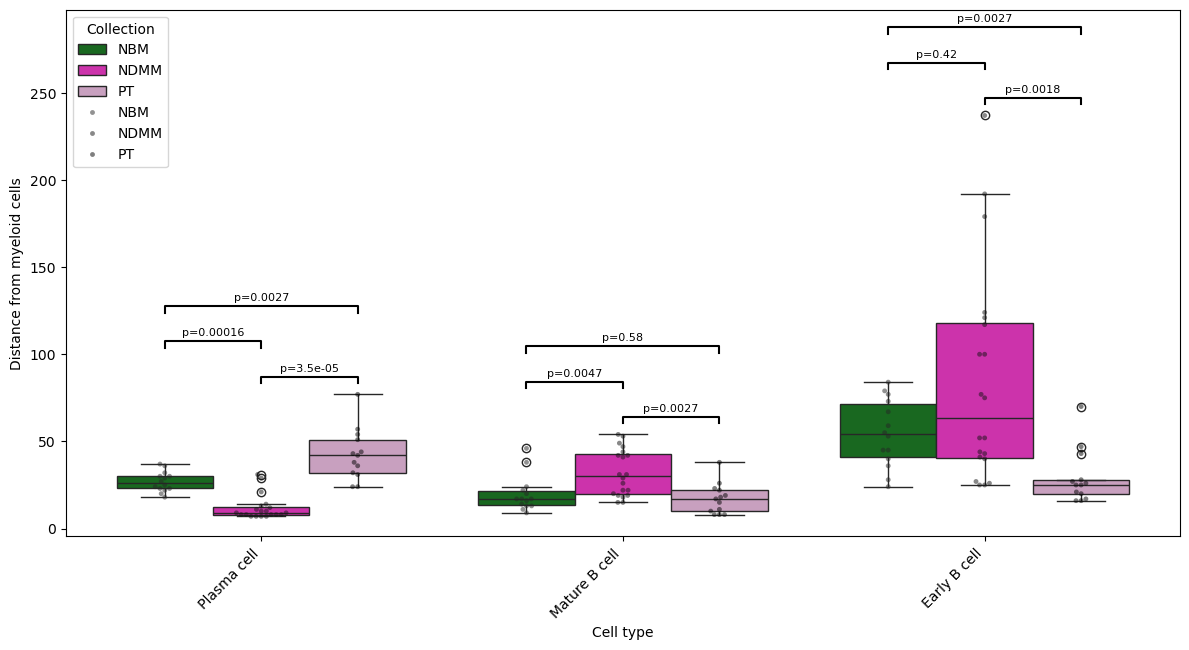

In [20]:
timecols = {"NBM": "#0C7515", "NDMM": "#E619B9", "PT": "#CF99C3"} 
_ = plot_utils.plot_multigroup_boxplot_with_significance(most_likely_dists_df, x_col = 'Reference Cell Type', y_col = 'Most Likely Distance', hue_col = 'Collection', show_swarm = True,
                                                    palette = timecols, figsize=(12, 6), xlabel='Cell type', ylabel='Distance from myeloid cells', title=None, save_path=None) 
plt.xticks(rotation=45, ha='right')


#plt.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_myeloid_nearestDist_to_PC_B_cells_boxplot_v11062025.pdf', dpi = 300, transparent = True)

### APRIL receptor expression vs distance in PC/B cells vs APRIL+ cells

In [128]:
april_pos = ird_v6[(ird_v6.obs['APRILpos'] == True) & (ird_v6.obs['ct'].isin(['GMP', 'Late Myeloid', 'Neutrophil', 'Monocyte', 'Macrophage','cDC', 'pDC'])), :]
#april_neg_pos = ird_v6[ird_v6.obs['APRILpos'] == False, :]
ird_pc = ird_v6[ird_v6.obs['ct'] == 'PC', :]
ird_b = ird_v6[(ird_v6.obs['ct'] == 'Mature B'), :]
april_dist_to_PC = spatial_utils.nearest_dist_between_two_celltypes(april_pos.obs.copy(), ird_pc.obs.copy(), sample_col='Sample', x_col='x_centroid', y_col='y_centroid')
april_dist_to_B = spatial_utils.nearest_dist_between_two_celltypes(april_pos.obs.copy(), ird_b.obs.copy(), sample_col='Sample', x_col='x_centroid', y_col='y_centroid')
#pc_dist_to_aprilneg = nearest_dist_between_two_celltypes(ird_pc.obs.copy(), april_neg_pos, sample_col='Sample', x_col='x_centroid', y_col='y_centroid')
#b_dist_to_aprilneg = nearest_dist_between_two_celltypes(ird_b.obs.copy(), april_neg_pos, sample_col='Sample', x_col='x_centroid', y_col='y_centroid')

In [129]:
bins = [0, 20, 50, np.inf]
bin_labels = ['0-20', '20-50', '>50']
april_pos.obs['dist_to_nearest_PC'] = april_dist_to_PC['nearest_dist_to_df2'].values
april_pos.obs['dist_to_nearest_B'] = april_dist_to_B['nearest_dist_to_df2'].values
#ird_pc.obs['dist_to_nearest_APRILneg'] = pc_dist_to_aprilneg['nearest_dist_to_df2'].values
#ird_b.obs['dist_to_nearest_APRILneg'] = b_dist_to_aprilneg['nearest_dist_to_df2'].values

april_pos.obs['dist_bin_to_nearest_PC'] = pd.cut(april_pos.obs['dist_to_nearest_PC'], 
                                                    bins = bins, 
                                                    labels = bin_labels)
april_pos.obs['dist_bin_to_nearest_B'] = pd.cut(april_pos.obs['dist_to_nearest_B'], 
                                                    bins=bins, 
                                                    labels = bin_labels)
#ird_pc.obs['dist_bin_to_nearest_APRILneg'] = pd.cut(ird_pc.obs['dist_to_nearest_APRILneg'], 
#                                                    bins=[0, 50, 100, 150, 200, np.inf], 
#                                                    labels = ['0-50', '50-100', '100-150', '150-200', '>200'])
#ird_b.obs['dist_bin_to_nearest_APRILneg'] = pd.cut(ird_b.obs['dist_to_nearest_APRILneg'], 
#                                                    bins=[0, 50, 100, 150, 200, np.inf], 
#                                                    labels = ['0-50', '50-100', '100-150', '150-200', '>200'])

/diskmnt/Users2/chouw/temp/ipykernel_60047/4039080420.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  april_pos.obs['dist_to_nearest_PC'] = april_dist_to_PC['nearest_dist_to_df2'].values


In [138]:
# For each sample, calculate the mean expression of APRIL in each distance bin
april_pos_pc_avg = april_pos.obs.groupby(['Sample', 'dist_bin_to_nearest_PC'])['APRIL_exp'].mean().reset_index()
april_pos_b_avg = april_pos.obs.groupby(['Sample', 'dist_bin_to_nearest_B'])['APRIL_exp'].mean().reset_index()
metadata = ird_cells_info[['Sample', 'Collection']].drop_duplicates().set_index('Sample')
april_pos_pc_avg['Collection'] = april_pos_pc_avg['Sample'].map(metadata['Collection'])
april_pos_b_avg['Collection'] = april_pos_b_avg['Sample'].map(metadata['Collection'])


/diskmnt/Users2/chouw/temp/ipykernel_60047/68599635.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  april_pos_pc_avg = april_pos.obs.groupby(['Sample', 'dist_bin_to_nearest_PC'])['APRIL_exp'].mean().reset_index()
/diskmnt/Users2/chouw/temp/ipykernel_60047/68599635.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  april_pos_b_avg = april_pos.obs.groupby(['Sample', 'dist_bin_to_nearest_B'])['APRIL_exp'].mean().reset_index()


/diskmnt/Users2/chouw/temp/ipykernel_60047/3242653386.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(april_pos_pc_avg, x = 'Collection', y = 'APRIL_exp', hue = 'dist_bin_to_nearest_PC', dodge = True, color = 'k', alpha = .5)


<Axes: xlabel='Collection', ylabel='APRIL_exp'>

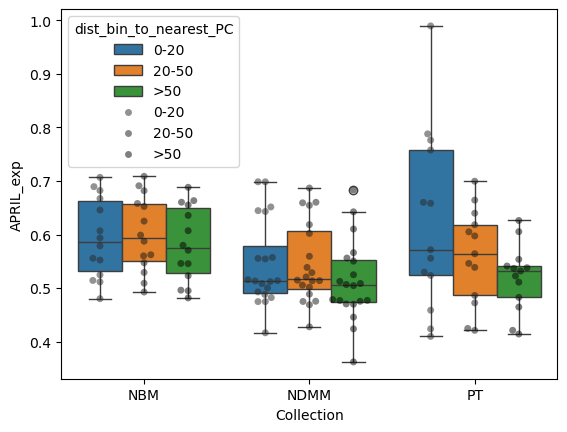

In [140]:
sns.boxplot(april_pos_pc_avg, x = 'Collection', y = 'APRIL_exp', hue = 'dist_bin_to_nearest_PC')
sns.swarmplot(april_pos_pc_avg, x = 'Collection', y = 'APRIL_exp', hue = 'dist_bin_to_nearest_PC', dodge = True, color = 'k', alpha = .5)

/diskmnt/Users2/chouw/temp/ipykernel_60047/3166547825.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(april_pos_b_avg, x = 'Collection', y = 'APRIL_exp', hue = 'dist_bin_to_nearest_B', dodge = True, color = 'k', alpha = .5)


<Axes: xlabel='Collection', ylabel='APRIL_exp'>

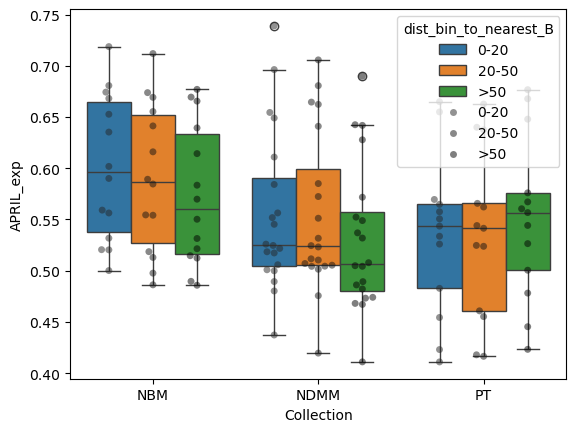

In [141]:
sns.boxplot(april_pos_b_avg, x = 'Collection', y = 'APRIL_exp', hue = 'dist_bin_to_nearest_B')
sns.swarmplot(april_pos_b_avg, x = 'Collection', y = 'APRIL_exp', hue = 'dist_bin_to_nearest_B', dodge = True, color = 'k', alpha = .5)

## Section 3: Myeloid Immunosuppression Analysis

Myeloid cells have been shown to be a source of a immunosuppression tumor microenvironment, such as myeloid-derived suppressive cells (MDSCs) and tumor-associated macrophages (TAMs). Due to the limited gene panel and the sparsity of transcript detection, we may not be able to identify these populations using unsupervised clustering of their Xenium transcript profiles. Alternatively, this section analyzes the expression of immune checkpoint molecules and immunosuppressive factors in myeloid populations (especially macrophages) across disease stages to identify changes in immunosuppressive capacity. 

### Genes associated with myeloid immunosuppression

Myeloid cells are assessed for immunosuppressive phenotype based on expression of the following markers:

**Immune checkpoint and immunosuppressive molecules:**
CD274 (PD-L1)(on all panel), SPP1, MARCO, IL1R2, IL1RL1, TGFB1 (on v5, v6 panel)

**Transcriptional regulators:**
STAT3, STAT1, NFKB1, NFKBIA

Cells expressing ≥1 of these markers are considered to have an immunosuppressive MDSC-like phenotype. We also test for spatial proximity to exhausted T cells, which are hypothesized to be induced by immunosuppressive myeloid cells. These T cells are identified by the following markers:

**T cell exhaustion markers**:
CTLA4, LAG3, HAVCR2 (TIM-3), TIGIT



In [8]:
ird_xenium_merge.obs['ct_timepoint'] = ird_xenium_merge.obs.apply(lambda x: f"{x['ct']}_{x['Collection']}", axis = 1)

PDL1 (CD274) is expressed at higher levels in macrophages and megakaryocytes. PDL1+ macrophages could represent a possible mMDSC phenotype. Megakaryocytes maybe somewhat novel players expressing PDL1.

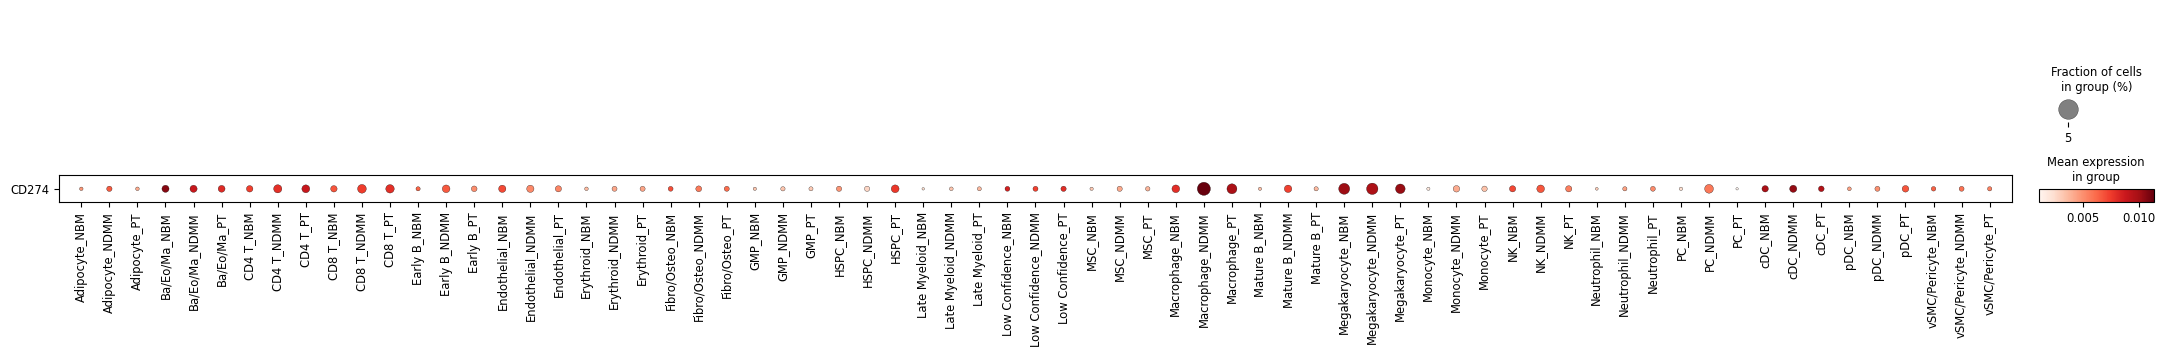

In [ ]:
sc.pl.dotplot(ird_xenium_merge, var_names = 'CD274', groupby = 'ct_timepoint', swap_axes = True, dot_max = 0.05)

In [12]:
ird_myeloid = ird_xenium_merge[ird_xenium_merge.obs['ct'].isin(['GMP', 'Late Myeloid', 'Neutrophil', 'Ba/Eo/Ma/', 'Monocyte', 'Macrophage', 'pDC', 'cDC']), :].copy()

In [9]:
timecols = {"NBM": "#0C7515", "NDMM": "#E619B9", "PT": "#CF99C3"} 

SPP1 expression is higher in macrophages in NDMM

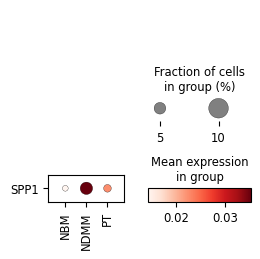

In [13]:
ird_macro = ird_myeloid[ird_myeloid.obs['ct'].isin(['Macrophage']), :].copy()
sc.pl.dotplot(ird_macro, var_names = 'SPP1', groupby = 'Collection', swap_axes = True)

/diskmnt/Users2/chouw/temp/ipykernel_62777/953862794.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_spp1_exp = ird_macro.obs.groupby('Sample')['SPP1_exp'].mean().reset_index()
/diskmnt/Users2/chouw/temp/ipykernel_62777/953862794.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_spp1_exp = macro_spp1_exp.merge(ird_macro.obs.groupby('Sample')['SPP1_pos'].mean().reset_index(), on='Sample', how='left')
/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

(<Figure size 600x500 with 1 Axes>,
   Group1 Group2      pval
 0    NBM   NDMM  0.001643
 1    NBM     PT  0.035046
 2   NDMM     PT  0.506942)

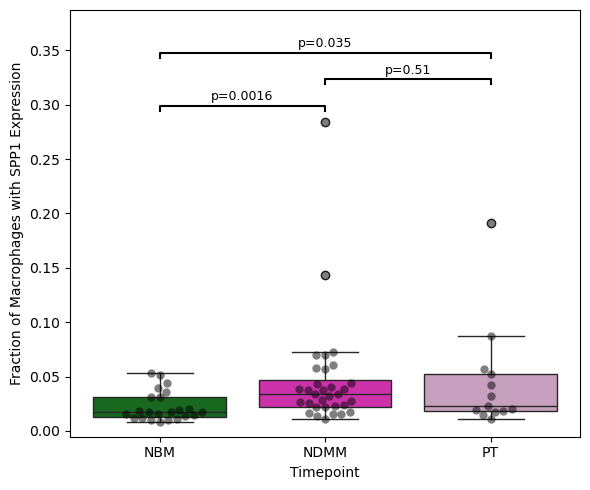

In [14]:
ird_macro.obs['SPP1_exp'] = ird_macro[:, 'SPP1'].X.toarray()
ird_macro.obs['SPP1_pos'] = ird_macro[:, 'SPP1'].X.toarray() > 0
macro_spp1_exp = ird_macro.obs.groupby('Sample')['SPP1_exp'].mean().reset_index()
macro_spp1_exp = macro_spp1_exp.merge(ird_macro.obs.groupby('Sample')['SPP1_pos'].mean().reset_index(), on='Sample', how='left')
macro_spp1_exp['Collection'] = macro_spp1_exp['Sample'].map(ird_xenium_merge.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')['Collection'])
plot_utils.plot_comparison_with_significance(macro_spp1_exp, 'Collection', 'SPP1_pos', order=['NBM', 'NDMM', 'PT'], 
                                             palette=timecols, xlabel = 'Timepoint', ylabel = 'Fraction of Macrophages with SPP1 Expression')
                                             #save_path = '/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_SPP1fraction.pdf')

PDL1 (CD274) expression in macrophages is higher in NDMM

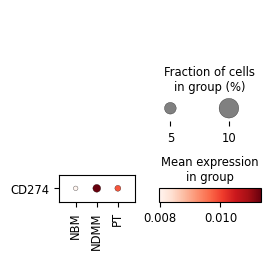

In [78]:
sc.pl.dotplot(ird_macro, var_names = 'CD274', groupby = 'Collection', swap_axes = True)

/diskmnt/Users2/chouw/temp/ipykernel_62777/4034820927.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_pdl1_exp = ird_macro.obs.groupby('Sample')['PDL1_exp'].mean().reset_index()
/diskmnt/Users2/chouw/temp/ipykernel_62777/4034820927.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_pdl1_exp = macro_pdl1_exp.merge(ird_macro.obs.groupby('Sample')['PDL1_pos'].mean().reset_index(), on='Sample', how='left')
/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign th

(<Figure size 600x500 with 1 Axes>,
   Group1 Group2      pval
 0    NBM   NDMM  0.001643
 1    NBM     PT  0.056106
 2   NDMM     PT  0.475419)

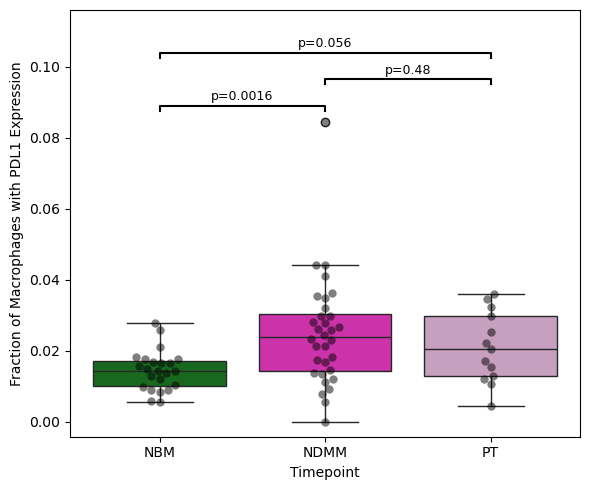

In [15]:
ird_macro.obs['PDL1_exp'] = ird_macro[:, 'CD274'].X.toarray()
ird_macro.obs['PDL1_pos'] = ird_macro[:, 'CD274'].X.toarray() > 0
macro_pdl1_exp = ird_macro.obs.groupby('Sample')['PDL1_exp'].mean().reset_index()
macro_pdl1_exp = macro_pdl1_exp.merge(ird_macro.obs.groupby('Sample')['PDL1_pos'].mean().reset_index(), on='Sample', how='left')
macro_pdl1_exp['Collection'] = macro_pdl1_exp['Sample'].map(ird_xenium_merge.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')['Collection'])
plot_utils.plot_comparison_with_significance(macro_pdl1_exp, 'Collection', 'PDL1_pos', order=['NBM', 'NDMM', 'PT'], 
                                             palette=timecols, xlabel = 'Timepoint', ylabel = 'Fraction of Macrophages with PDL1 Expression')
                                             #save_path = '/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_PDL1fraction.pdf')

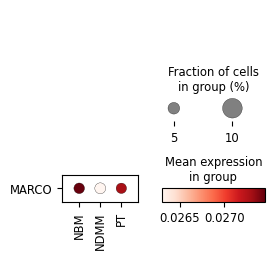

In [79]:
sc.pl.dotplot(ird_macro, var_names = 'MARCO', groupby = 'Collection', swap_axes = True)

/diskmnt/Users2/chouw/temp/ipykernel_266254/2321519162.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_marco_exp = ird_macro.obs.groupby('Sample')['MARCO_exp'].mean().reset_index()
/diskmnt/Users2/chouw/temp/ipykernel_266254/2321519162.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_marco_exp = macro_marco_exp.merge(ird_macro.obs.groupby('Sample')['MARCO_pos'].mean().reset_index(), on='Sample', how='left')
/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. As

(<Figure size 600x500 with 1 Axes>,
   Group1 Group2      pval
 0    NBM   NDMM  0.086374
 1    NBM     PT  0.717141
 2   NDMM     PT  0.310491)

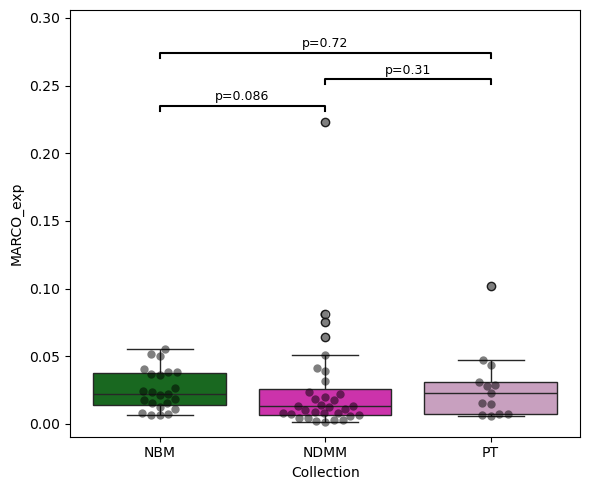

In [82]:
ird_macro.obs['MARCO_exp'] = ird_macro[:, 'MARCO'].X.toarray()
ird_macro.obs['MARCO_pos'] = ird_macro[:, 'MARCO'].X.toarray() > 0
macro_marco_exp = ird_macro.obs.groupby('Sample')['MARCO_exp'].mean().reset_index()
macro_marco_exp = macro_marco_exp.merge(ird_macro.obs.groupby('Sample')['MARCO_pos'].mean().reset_index(), on='Sample', how='left')
macro_marco_exp['Collection'] = macro_marco_exp['Sample'].map(ird_xenium_merge.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')['Collection'])
plot_utils.plot_comparison_with_significance(macro_marco_exp, 'Collection', 'MARCO_exp', order=['NBM', 'NDMM', 'PT'], palette=timecols)

### Immunosuppression gene set scores

Both SPP1+ macrophages and PDL1+ macrophages have been reported to exhibit immunosuppressive activities.

Due to their sparse expression and the lack of relevant MDSC/SPP1+ macrophage markers, we use a geneset score approach to identify macrophages that are likely to exhibit immunosuppressive capacities.

We include both SPP1 and CD274 (PDL1) as part of this gene set. While MARCO expression is lower in macrophages in NDMM, it's reported to be a marker of SPP1+ macrophages. As a result, we still included MARCO for the geneset score calculation.

In [16]:
sc.tl.score_genes(ird_macro, gene_list = ['SPP1', 'CD274', 'MARCO'], score_name = 'ImmSupp_score')

<Axes: xlabel='ImmSupp_score', ylabel='Count'>

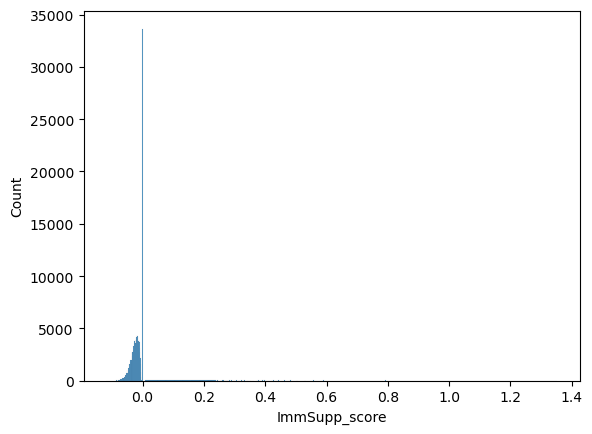

In [17]:
sns.histplot(ird_macro.obs['ImmSupp_score'])

Validate the expression of other markers that are reported to be associated with SPP1+ macrophages and MDSC activities.

In [18]:
ird_macro.obs['ImmSupp_score_high'] = ['high' if x > 0 else 'low' for x in ird_macro.obs['ImmSupp_score']]
dotplot = sc.pl.dotplot(ird_macro, var_names = ['SPP1', 'CD274', 'MARCO'], groupby = 'ImmSupp_score_high', return_fig = True)
#dotplot.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_ImmSuppScore_SPP1CD274MARCO.pdf', dpi = 300)


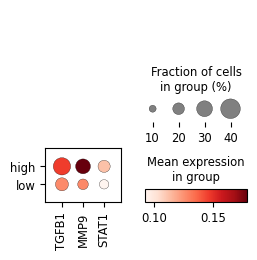

In [152]:
dotplot = sc.pl.dotplot(ird_macro, var_names = ['TGFB1', 'MMP9', 'STAT1'], groupby = 'ImmSupp_score_high', return_fig = True)
dotplot.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_ImmSuppScore_TGFB1MMP9STAT1.pdf', dpi = 300)

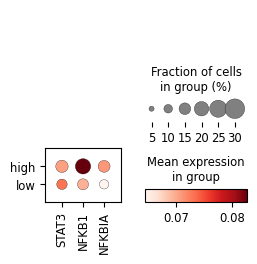

In [147]:
dotplot = sc.pl.dotplot(ird_macro, var_names = ['STAT3', 'NFKB1', 'NFKBIA'], groupby = 'ImmSupp_score_high', return_fig = True)
dotplot.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_ImmSuppScore_STAT3NFKB1NFKBIA.pdf', dpi = 300)

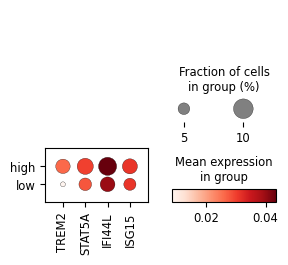

In [153]:
dotplot = sc.pl.dotplot(ird_macro, var_names = ['TREM2', 'STAT5A', 'IFI44L', 'ISG15'], groupby = 'ImmSupp_score_high', return_fig = True)
dotplot.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_ImmSuppScore_TREM2STAT5AIFI44LISG15.pdf', dpi = 300)

Validate if macrophages with high immunosuppression scores are enriched in NDMM

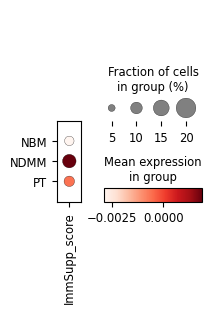

In [150]:
dotplot = sc.pl.dotplot(ird_macro, var_names = 'ImmSupp_score', groupby = 'Collection', return_fig = True)
dotplot.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_ImmSuppScore_timepoint.pdf', dpi = 300)

/diskmnt/Users2/chouw/temp/ipykernel_62777/2180393592.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ird_macro_immSupp_summary = ird_macro.obs.groupby(['Sample'])['ImmSupp_score_pos'].mean().reset_index()
/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, order=order, palette=palette, ax=ax)


(<Figure size 600x500 with 1 Axes>,
   Group1 Group2      pval
 0    NBM   NDMM  0.044972
 1    NBM     PT  0.056106
 2   NDMM     PT  0.851023)

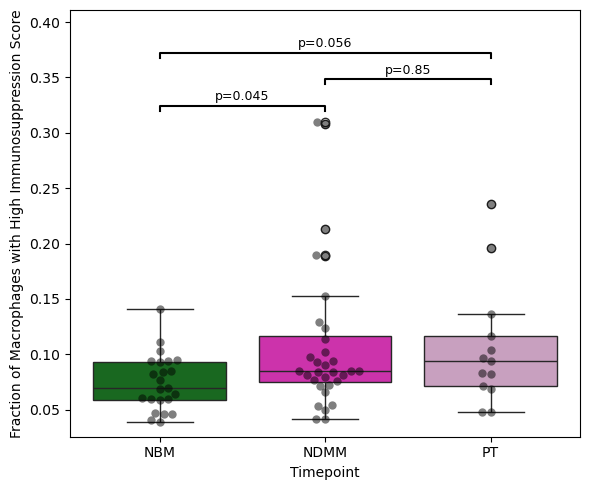

In [19]:
# Percent macrophage with high SPP1 score per sample, grouped by Collection
ird_macro.obs['ImmSupp_score_pos'] = ird_macro.obs['ImmSupp_score'] > 0.
ird_macro_immSupp_summary = ird_macro.obs.groupby(['Sample'])['ImmSupp_score_pos'].mean().reset_index()
ird_macro_immSupp_summary = ird_macro_immSupp_summary.merge(ird_macro.obs[['Sample', 'Collection']].drop_duplicates(), on='Sample', how='left')
plot_utils.plot_comparison_with_significance(ird_macro_immSupp_summary, 'Collection', 'ImmSupp_score_pos', order=['NBM', 'NDMM', 'PT'], palette=timecols, 
                                       xlabel='Timepoint', ylabel='Fraction of Macrophages with High Immunosuppression Score', title=None)
                                       #save_path='/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_macrophage_ImmSuppScoreFrac.pdf', figsize=(6, 5))



Validate if macrophages with high immunosuppression scores have higher expression of other SPP1/MDSC markers in NDMM.

In [111]:
ird_macro_immSupp = ird_macro[ird_macro.obs['ImmSupp_score_high'] == 'high', :].copy()

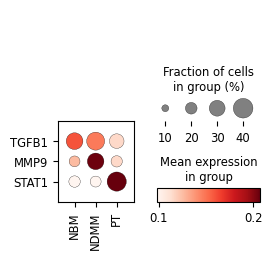

In [112]:
sc.pl.dotplot(ird_macro_immSupp, var_names = ['TGFB1', 'MMP9', 'STAT1'], groupby = 'Collection', swap_axes = True)

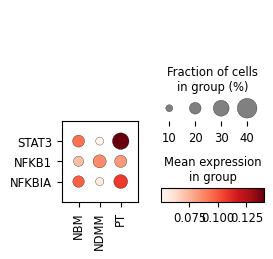

In [113]:
sc.pl.dotplot(ird_macro_immSupp, var_names = ['STAT3', 'NFKB1', 'NFKBIA'], groupby = 'Collection', swap_axes = True)

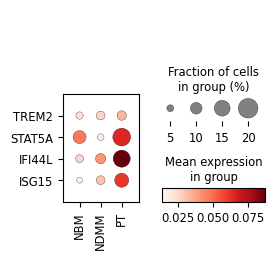

In [114]:
sc.pl.dotplot(ird_macro_immSupp, var_names = ['TREM2', 'STAT5A', 'IFI44L', 'ISG15'], groupby = 'Collection', swap_axes = True)

### Spatial localization of immunosuppressive macrophages

Are the macrophages enriched in certain radial neighborhoods? Radial neighborhoods were defined by Julia, which clusters neighbor composition within 50 microns of each cell.

In [7]:
rn_obj = sc.read_h5ad('/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/radial_neighborhoods/Output/merged_RN.h5ad')
rn_obj.obs.head()


,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,DI_Sample,Collection,Panel,MRD.Status,Months_PFS,nCounts,annot,clust,ct,Original_Barcode,rn
IRD_S18-30740A1U3_aaaefkpp-1,433.430206,1357.545288,37.660314,23.932813,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,136.0,Erythro,Erythroid,Erythroid,aaaefkpp-1,RN2
IRD_S18-30740A1U3_aaaekejm-1,449.853851,1278.230225,31.067501,20.817032,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,115.0,Granulo,Late Myeloid,Late Myeloid,aaaekejm-1,RN2
IRD_S18-30740A1U3_aaaekekb-1,438.366547,1361.509277,46.240002,17.340001,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,137.0,Erythro,NK_T,NK,aaaekekb-1,RN2
IRD_S18-30740A1U3_aaaeonma-1,438.007660,1311.078979,125.715005,59.380471,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,291.0,Erythro,Erythroid,Erythroid,aaaeonma-1,RN2
IRD_S18-30740A1U3_aaaflkno-1,373.216797,1557.585327,46.194845,30.480470,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,88.0,Erythro,Erythroid,Erythroid,aaaflkno-1,RN2


In [82]:
# Count number of cells in each radial neighborhood
rn_counts = rn_obj.obs['rn'].value_counts().reset_index()
rn_counts

,rn,count
0,RN1,1015897
1,RN2,1000314
2,RN3,802623
3,RN4,646057
4,RN5,449677
5,RN6,440050
6,RN7,339507
7,RN8,333310
8,RN9,264424
9,RN10,253501


In [ ]:
# Add radial neighborhood information to the macrophage data
ird_macro.obs['rn'] = rn_obj.obs.loc[ird_macro.obs.index, 'rn'].values

Calculate the fraction of macrophages that are immunosuppressive in each radial neighborhood. They are more enriched in:
- nbhd 8: CD8 T/NK cell neighborhood
- nbhd 9: stromal neighborhood
- nbhd 12 (few cells per sample): osteoblast neighborhood

In [34]:
# Count the number of macrophages in each radial neighborhood, grouped by ImmSupp_score_pos
macro_rn_counts = (
    ird_macro.obs
    .groupby(['rn', 'ImmSupp_score_pos'])
    .size()
    .reset_index(name='macrophage_count')
)
macro_rn_counts = macro_rn_counts.merge(rn_counts, on='rn', how='left')
macro_rn_counts['macrophage_frac'] = macro_rn_counts['macrophage_count'] / macro_rn_counts['count']
display(macro_rn_counts)



/diskmnt/Users2/chouw/temp/ipykernel_62777/2484101843.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['rn', 'ImmSupp_score_pos'])


,rn,ImmSupp_score_pos,macrophage_count,count,macrophage_frac
0,RN1,False,22105,1015897,0.021759
1,RN1,True,2095,1015897,0.002062
2,RN2,False,28172,1000314,0.028163
3,RN2,True,2544,1000314,0.002543
4,RN3,False,20350,802623,0.025354
5,RN3,True,2418,802623,0.003013
6,RN4,False,21912,646057,0.033917
7,RN4,True,2314,646057,0.003582
8,RN5,False,11143,449677,0.024780
9,RN5,True,896,449677,0.001993


<Axes: xlabel='macrophage_frac', ylabel='rn'>

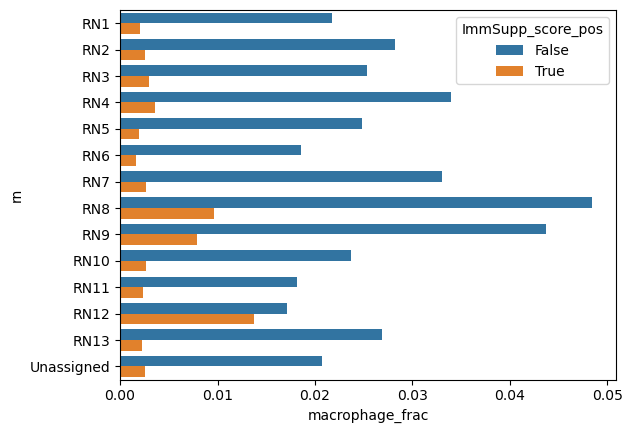

In [35]:
sns.barplot(macro_rn_counts, x = 'macrophage_frac', y = 'rn', hue = 'ImmSupp_score_pos')

Calculate the fraction of macrophages that are immunnosuppressive per radial neighborhood on a sample level, and compare across collection timepoints.

In [87]:
macro_per_sample_rn = ird_macro.obs.groupby(['Sample', 'rn']).agg(
    macrophage_count = ('rn', 'count'),
    immSupp_count = ('ImmSupp_score_pos', 'sum')
).reset_index()
macro_per_sample_rn['macrophage_frac'] = macro_per_sample_rn['macrophage_count'] / macro_per_sample_rn['macrophage_count'].sum()
macro_per_sample_rn['immSupp_frac'] = macro_per_sample_rn['immSupp_count'] / macro_per_sample_rn['macrophage_count']
macro_per_sample_rn['immSupp_frac'] = macro_per_sample_rn['immSupp_frac'].fillna(0)
macro_per_sample_rn['Collection'] = macro_per_sample_rn['Sample'].map(ird_xenium_merge.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')['Collection'])
macro_per_sample_rn.head()

/diskmnt/Users2/chouw/temp/ipykernel_62777/1488406349.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  macro_per_sample_rn = ird_macro.obs.groupby(['Sample', 'rn']).agg(


,Sample,rn,macrophage_count,immSupp_count,macrophage_frac,immSupp_frac,Collection
0,IRD_S18-30740A1U3,RN1,118,19,0.000659,0.161017,NDMM
1,IRD_S18-30740A1U3,RN2,1308,131,0.007306,0.100153,NDMM
2,IRD_S18-30740A1U3,RN3,1330,101,0.007429,0.075940,NDMM
3,IRD_S18-30740A1U3,RN4,25,6,0.000140,0.240000,NDMM
4,IRD_S18-30740A1U3,RN5,46,2,0.000257,0.043478,NDMM


/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:153: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(df, x = x_col, y = y_col, hue = hue_col, order=order, hue_order=hue_order, dodge = True, color = 'k', alpha = 0.5, size = 3.5)
/diskmnt/Users2/chouw/Software/miniforge3/envs/scanpy/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 30.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/diskmnt/Users2/chouw/Software/miniforge3/envs/scanpy/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/diskmnt/Users2/chouw/Software/miniforge3/envs/scanpy/lib/python3.11/site-packages/seaborn/categorica

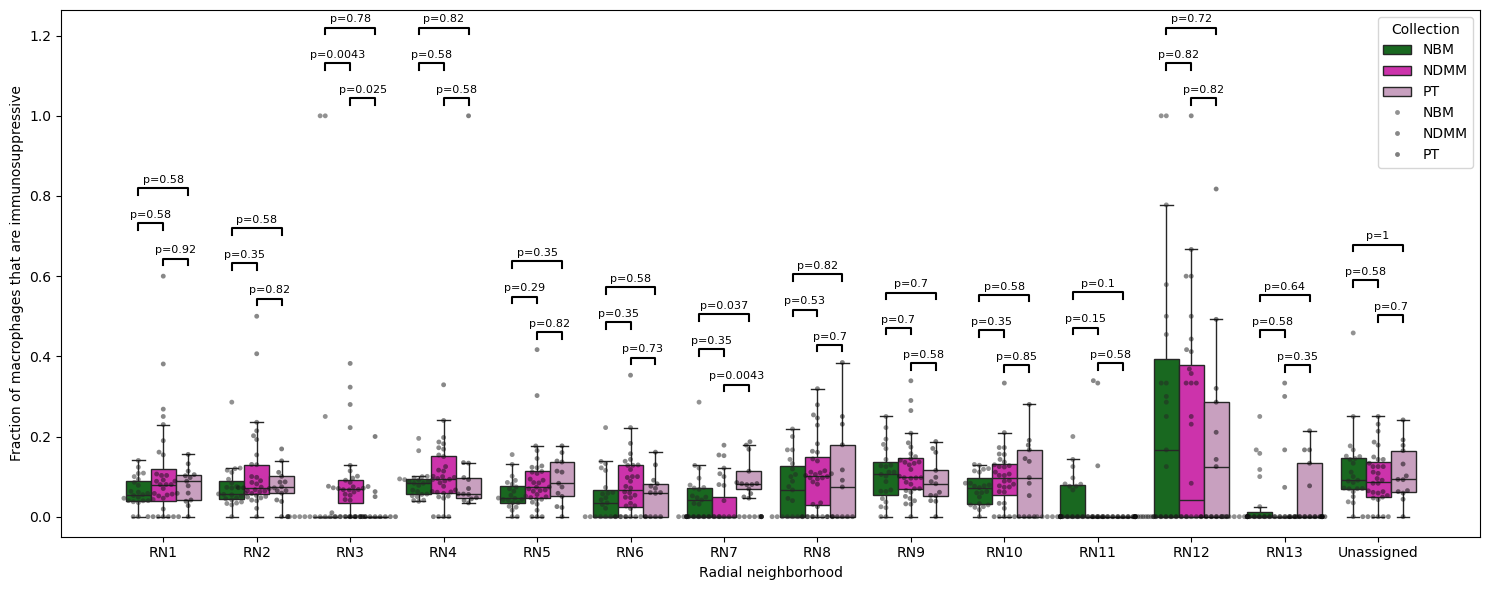

In [93]:
_ = plot_utils.plot_multigroup_boxplot_with_significance(macro_per_sample_rn, 'rn', 'immSupp_frac', 'Collection', figsize = (15, 6), show_outliers = False,
                                                     xlabel = 'Radial neighborhood', ylabel = 'Fraction of macrophages that are immunosuppressive',
                                                     palette = timecols, save_path = '/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_frac_ImmSupp_macrophage_rn_timepoint.pdf')


### Visualize spatial location of immunosuppressive macrophages

Scatterplot of cell centroids of macrophages, grouped by their immunosuppressive gene expression, and plasma cells (tumor).

In [122]:
test_sample = 'S13-35096A1U1'
ird_macro_test_meta = ird_macro.obs.loc[ird_macro.obs['Sample'] == test_sample, :].copy()
ird_pc_test_meta = ird_xenium_merge.obs.loc[(ird_xenium_merge.obs['Sample'] == test_sample) & (ird_xenium_merge.obs['ct'] == 'PC'), :].copy()
ird_test_meta = pd.concat([ird_macro_test_meta, ird_pc_test_meta], axis = 0)
ird_test_meta.head()



,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,DI_Sample,Collection,Panel,...,SPP1_pos,PDL1_exp,PDL1_pos,MARCO_exp,MARCO_pos,SPP1_score,SPP1_score_high,ImmSupp_score,ImmSupp_score_high,ImmSupp_score_pos
S13-35096A1U1_acglgeli-1,1925.968018,1207.028687,44.162814,27.319532,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,False,0.0,False,0.253781,True,0.064304,high,0.064304,high,True
S13-35096A1U1_adbfflle-1,1122.673584,2492.832764,43.982189,26.777657,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,False,0.0,False,0.000000,False,-0.022187,low,-0.022187,low,False
S13-35096A1U1_aehpeeep-1,1696.556885,7113.319824,98.892191,14.901563,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,False,0.0,False,0.000000,False,-0.009610,low,-0.009610,low,False
S13-35096A1U1_aeocfpml-1,1908.321289,7226.104980,88.235316,30.886876,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,False,0.0,False,0.000000,False,-0.020553,low,-0.020553,low,False
S13-35096A1U1_afkphgje-1,1444.357178,7530.629395,47.775314,27.680782,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,False,0.0,False,0.000000,False,0.000000,low,0.000000,low,False


In [124]:
# Defind subtypes: PCs remain PCs, macrophages are split into ImmSupp and Non-ImmSupp
ird_test_meta['ct_subtype'] = ['PC' if x == 'PC' else 'ImmSupp' if x == 'Macrophage' and y == 'high' else 'Non-ImmSupp' for x, y in zip(ird_test_meta['ct'], ird_test_meta['ImmSupp_score_high'])]
ird_test_meta.head()

,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,DI_Sample,Collection,Panel,...,PDL1_exp,PDL1_pos,MARCO_exp,MARCO_pos,SPP1_score,SPP1_score_high,ImmSupp_score,ImmSupp_score_high,ImmSupp_score_pos,ct_subtype
S13-35096A1U1_acglgeli-1,1925.968018,1207.028687,44.162814,27.319532,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,0.0,False,0.253781,True,0.064304,high,0.064304,high,True,ImmSupp
S13-35096A1U1_adbfflle-1,1122.673584,2492.832764,43.982189,26.777657,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,0.0,False,0.000000,False,-0.022187,low,-0.022187,low,False,Non-ImmSupp
S13-35096A1U1_aehpeeep-1,1696.556885,7113.319824,98.892191,14.901563,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,0.0,False,0.000000,False,-0.009610,low,-0.009610,low,False,Non-ImmSupp
S13-35096A1U1_aeocfpml-1,1908.321289,7226.104980,88.235316,30.886876,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,0.0,False,0.000000,False,-0.020553,low,-0.020553,low,False,Non-ImmSupp
S13-35096A1U1_afkphgje-1,1444.357178,7530.629395,47.775314,27.680782,S13-35096A1U1,10483,P138,P138_T0_S1,NDMM,BYGXJ6_hMulti,...,0.0,False,0.000000,False,0.000000,low,0.000000,low,False,Non-ImmSupp


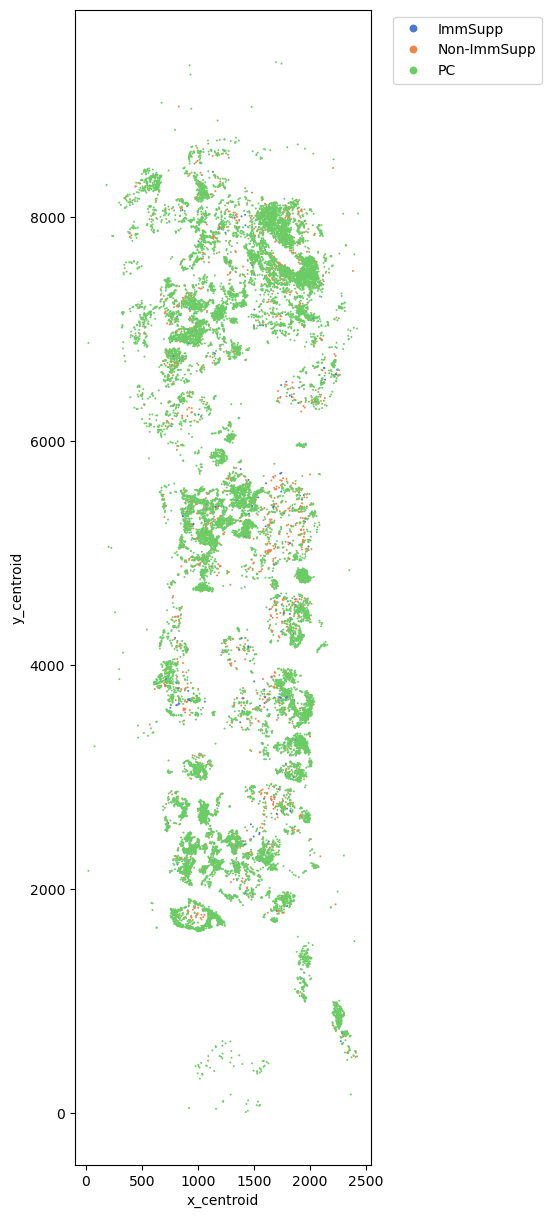

In [135]:
plt.figure(figsize = (15, 15))
sns.scatterplot(ird_test_meta, x = 'x_centroid', y = 'y_centroid', hue = 'ct_subtype', palette = 'muted', s = 2, linewidth = 0)
# Maintain aspect ratio
plt.gca().set_aspect('equal', 'box')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 4)

## Section 4: Stromal Niche Dysfunction - MSC Analysis

Characterize mesenchymal stromal cells (MSCs) and their functional changes across disease stages. MSCs are critical components of the bone marrow niche that support hematopoiesis and regulate plasma cell survival through factors like CXCL12. We test if CXCL12 expression in MSCs are significantly altered in disease and treatment.

In [15]:
ird_msc = ird_xenium_merge[ird_xenium_merge.obs['ct'] == 'MSC'].copy()

In [99]:
ird_msc_v6 = ird_msc[ird_msc.obs['Panel'] == 'BYGXJ6_hMulti'].copy()

In [42]:
sc.tl.rank_genes_groups(ird_msc_v6, groupby ='Collection', method = 'wilcoxon')

[<Axes: title={'center': 'NBM vs. rest'}, xlabel='ranking', ylabel='score'>,
 <Axes: title={'center': 'NDMM vs. rest'}, xlabel='ranking'>,
 <Axes: title={'center': 'PT vs. rest'}, xlabel='ranking'>]

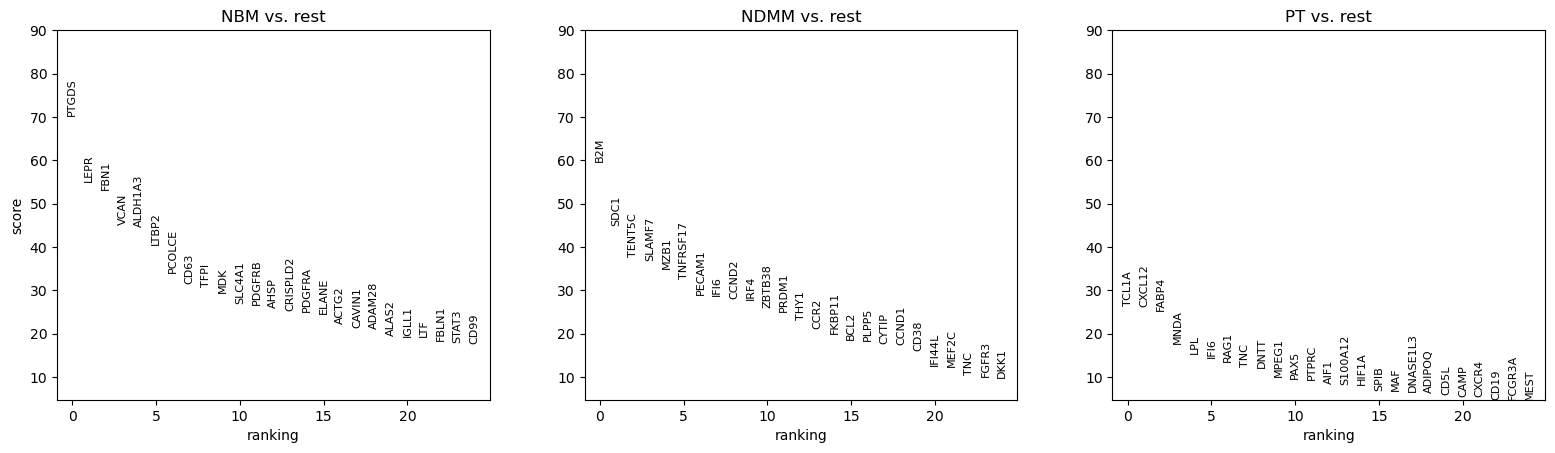

In [43]:
sc.pl.rank_genes_groups(ird_msc_v6, n_genes = 25, show = False)

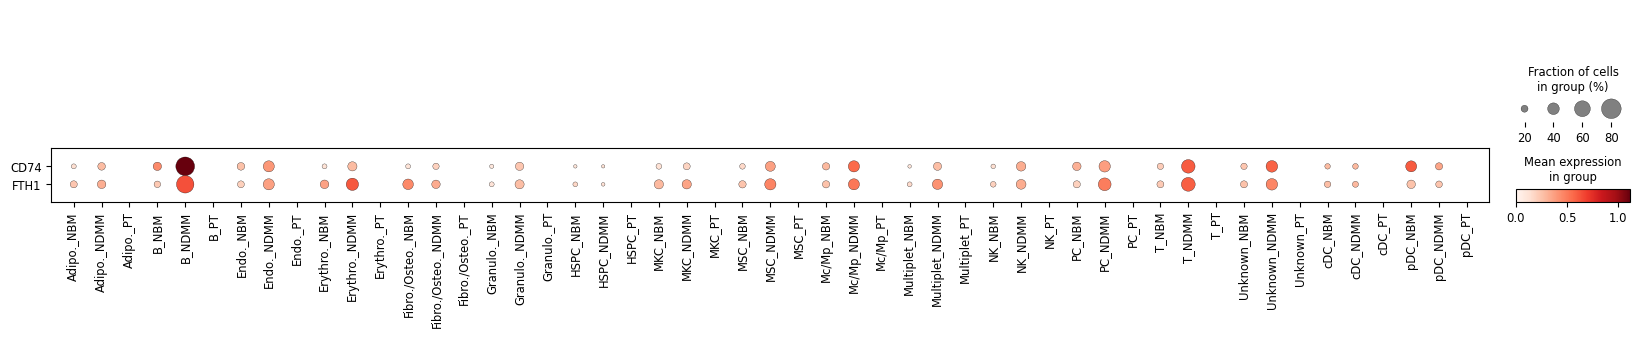

In [58]:
sc.pl.dotplot(ird_xenium_merge, var_names = ['CD74', 'FTH1'], groupby = 'annot_timepoint', swap_axes = True)

### Plasma cell contamination issue

Initial differential expression analysis reveals MSCs in NDMM samples are heavily confounded by plasma cell gene expression. This contamination likely arises from:
1. **Transcript leakage**: High plasma cell abundance leads transcript leakage to neighboring cells
2. **Segmentation errors**: Cells near plasma cells may incorrectly capture plasma transcripts

**Solution**: Apply stringent filtering to remove MSCs expressing canonical plasma cell markers before analyzing MSC-specific gene expression changes.

In [16]:
# Stringent filtering - remove MSCs with any expression of plasma cell genes SDC1, SLAMF7, MZB1, TNFRSF17
msc_PCexp = ird_msc[:, ['SDC1', 'SLAMF7', 'MZB1', 'TNFRSF17', 'B2M', 'TENT5C', 'CD74']].X.toarray().sum(axis=1)
ird_msc.obs['PC_exp'] = msc_PCexp > 1e-6
ird_msc_PC_filtered = ird_msc[ird_msc.obs['PC_exp'] == False].copy()
len(ird_msc_PC_filtered)



37921

### CXCL12/CXCR4 axis analysis

The **CXCL12-CXCR4 axis** is critical for plasma cell homing and retention in the bone marrow niche:

- **CXCL12** (SDF-1): Chemokine produced by MSCs and other stromal cells that attracts CXCR4+ cells
- **CXCR4**: Chemokine receptor expressed on plasma cells and B cell precursors

**Analysis approach:**
1. Quantify CXCL12 expression in filtered MSCs across disease stages
2. Quantify CXCR4 expression in B-lineage cells (Early B, Mature B, Plasma cells)


**Interpretation notes:**
- Decreased MSC CXCL12 may indicate stromal dysfunction and reduced niche support
- Altered CXCR4 levels in plasma cells may affect their retention and survival in the niche
- Cellchat analysis using Xenium data (done separately) indicate that CXCL12-CXCR4 signaling axis is affected



In [101]:
sc.tl.rank_genes_groups(ird_msc_PC_filtered, groupby ='Collection', method = 'wilcoxon')

[<Axes: title={'center': 'NBM vs. rest'}, xlabel='ranking', ylabel='score'>,
 <Axes: title={'center': 'NDMM vs. rest'}, xlabel='ranking'>,
 <Axes: title={'center': 'PT vs. rest'}, xlabel='ranking'>]

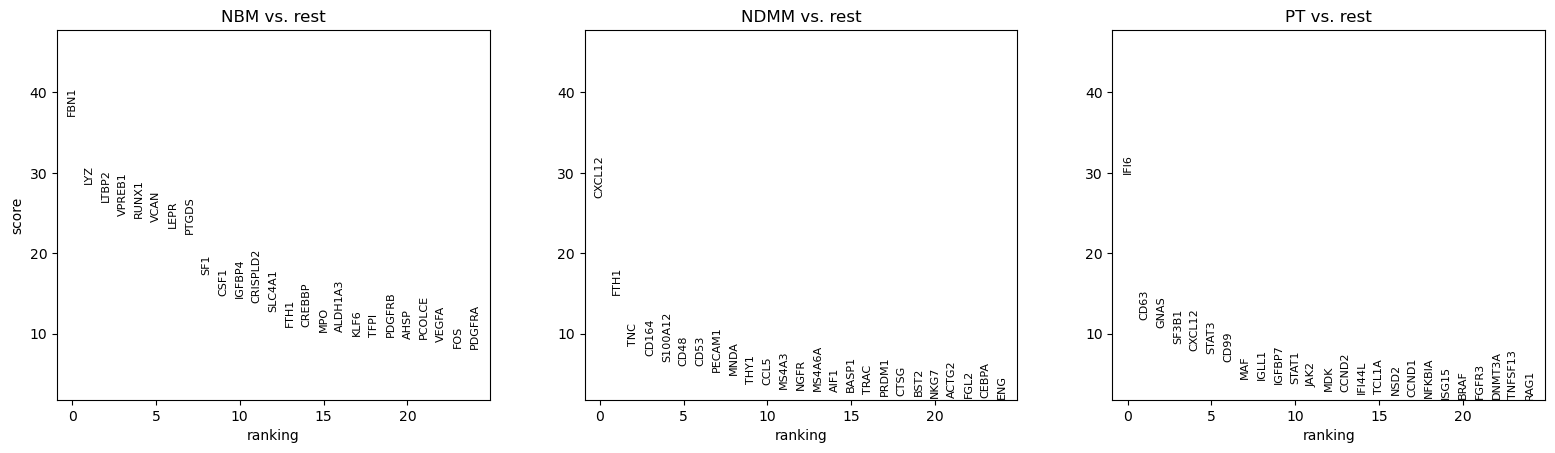

In [102]:
sc.pl.rank_genes_groups(ird_msc_PC_filtered, n_genes = 25, show = False)

[<Axes: title={'center': 'NBM vs. rest'}, xlabel='ranking', ylabel='score'>,
 <Axes: title={'center': 'NDMM vs. rest'}, xlabel='ranking'>,
 <Axes: title={'center': 'PT vs. rest'}, xlabel='ranking'>]

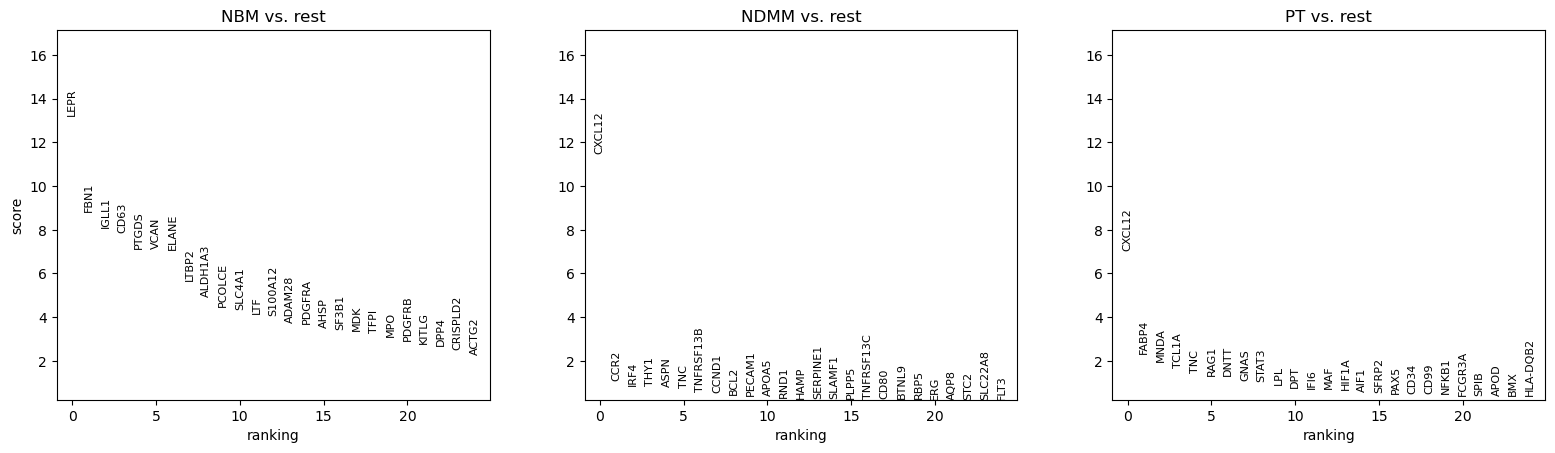

In [66]:
ird_msc_PC_filtered_v6 = ird_msc_PC_filtered[ird_msc_PC_filtered.obs['Panel'] == 'BYGXJ6_hMulti'].copy()
sc.tl.rank_genes_groups(ird_msc_PC_filtered_v6, groupby ='Collection', method = 'wilcoxon')
sc.pl.rank_genes_groups(ird_msc_PC_filtered_v6, n_genes = 25, show = False)

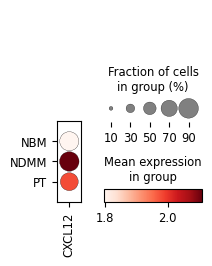

In [103]:
sc.pl.dotplot(ird_msc_PC_filtered, var_names = ['CXCL12'], groupby = 'Collection')

/diskmnt/Users2/chouw/temp/ipykernel_65620/754251990.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cxcl12_exp = ird_msc_PC_filtered.obs.groupby('Sample')['CXCL12_exp'].mean().reset_index()
/diskmnt/Users2/chouw/temp/ipykernel_65620/838381550.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=x_col, y=y_col, order=order, palette=palette, ax=ax)


(<Figure size 600x500 with 1 Axes>,
   Group1 Group2      pval
 0    NBM   NDMM  0.077391
 1    NBM     PT  0.843351
 2   NDMM     PT  0.347697)

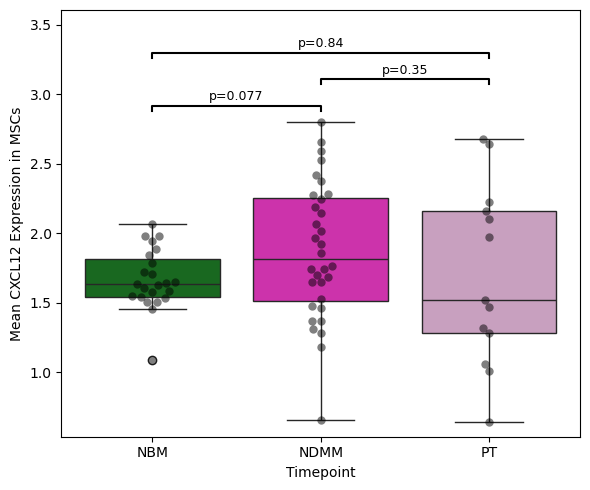

In [ ]:
ird_msc_PC_filtered.obs['CXCL12_exp'] = ird_msc_PC_filtered[:, 'CXCL12'].X.toarray().flatten()
cxcl12_exp = ird_msc_PC_filtered.obs.groupby('Sample')['CXCL12_exp'].mean().reset_index()
cxcl12_exp['Collection'] = cxcl12_exp['Sample'].map(ird_msc_PC_filtered.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')['Collection'])

timecols = {"NBM": "#0C7515", "NDMM": "#E619B9", "PT": "#CF99C3"} 
plot_utils.plot_comparison_with_significance(cxcl12_exp, 'Collection', 'CXCL12_exp', order=['NBM', 'NDMM', 'PT'], palette=timecols, 
                                       xlabel='Timepoint', ylabel='Mean CXCL12 Expression in MSCs', title=None,
                                       save_path='/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_Xenium_merge_CXCL12_expression_boxplot_v111125.pdf', figsize=(6, 5))

/diskmnt/Users2/chouw/temp/ipykernel_56202/1383310871.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cxcr4_exp = ird_B_lineage.obs.groupby(['Sample', 'ct'])['CXCR4_exp'].mean().reset_index()
/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:153: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  # Step 3: Draw significance bars, avoiding overlap
/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  


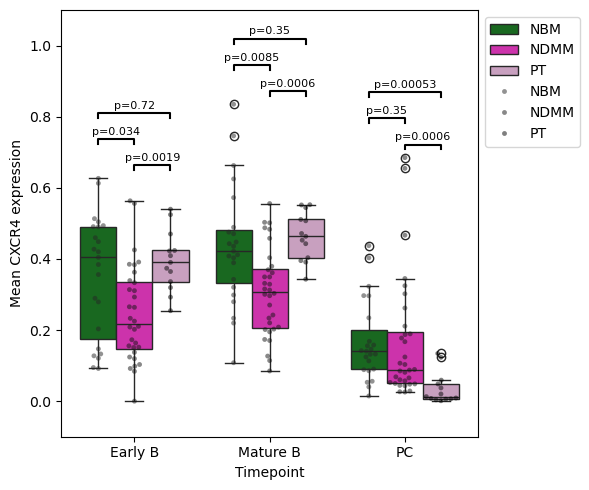

In [17]:
# Boxplot of mean CXCR4 expression in PC, Mature B, and Early B cells per sample, grouped by Collection
ird_B_lineage = ird_xenium_merge[ird_xenium_merge.obs['ct'].isin(['PC', 'Mature B', 'Early B'])].copy()
ird_B_lineage.obs['CXCR4_exp'] = ird_B_lineage[:, 'CXCR4'].X.toarray().flatten()
cxcr4_exp = ird_B_lineage.obs.groupby(['Sample', 'ct'])['CXCR4_exp'].mean().reset_index()
cxcr4_exp['Collection'] = cxcr4_exp['Sample'].map(ird_B_lineage.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')['Collection'])

timecols = {"NBM": "#0C7515", "NDMM": "#E619B9", "PT": "#CF99C3"} 
order = cxcr4_exp['ct'].unique().tolist()          # set your desired x order
hue_order = sorted(cxcr4_exp['Collection'].unique())  # set your desired hue order

plot_utils.plot_multigroup_boxplot_with_significance(cxcr4_exp, x_col='ct', y_col='CXCR4_exp', hue_col='Collection', 
                                                     order=order, hue_order=hue_order, show_swarm=True, 
                                                     palette=timecols, figsize=(6, 5), xlabel='Timepoint', ylabel='Mean CXCR4 expression', title=None, save_path=None)
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig('/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_Xenium_merge_CXCR4_expression_boxplot_v111125.pdf', dpi = 300)

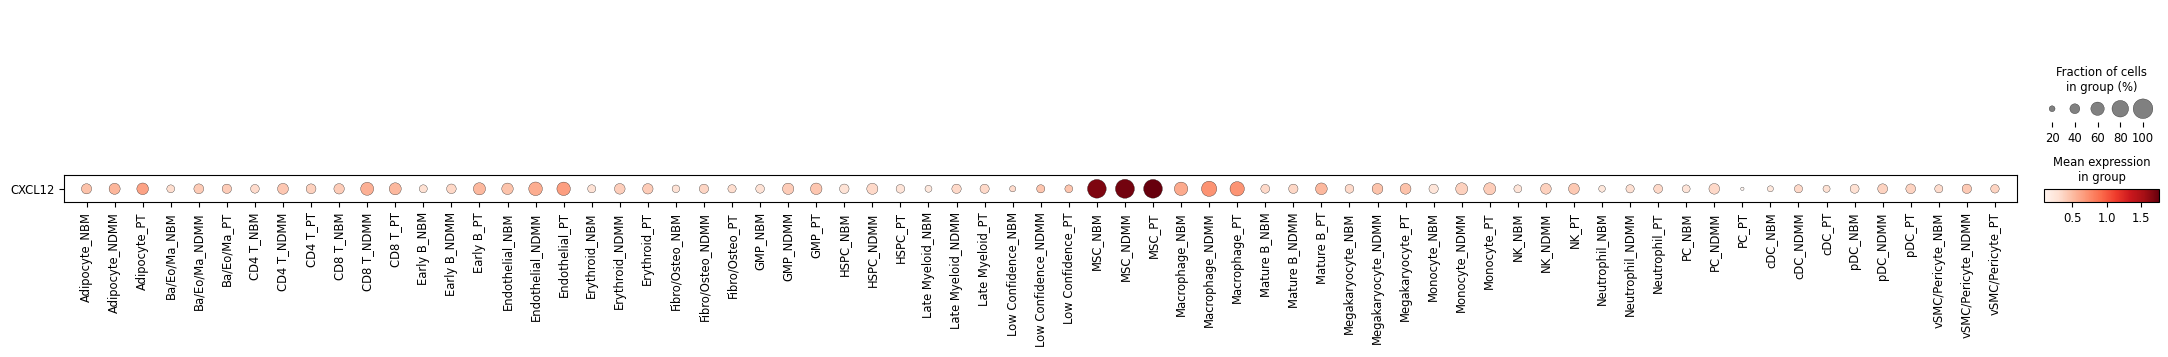

In [28]:
sc.pl.dotplot(ird_xenium_merge, var_names = ['CXCL12'], groupby = 'ct_timepoint', swap_axes = True)

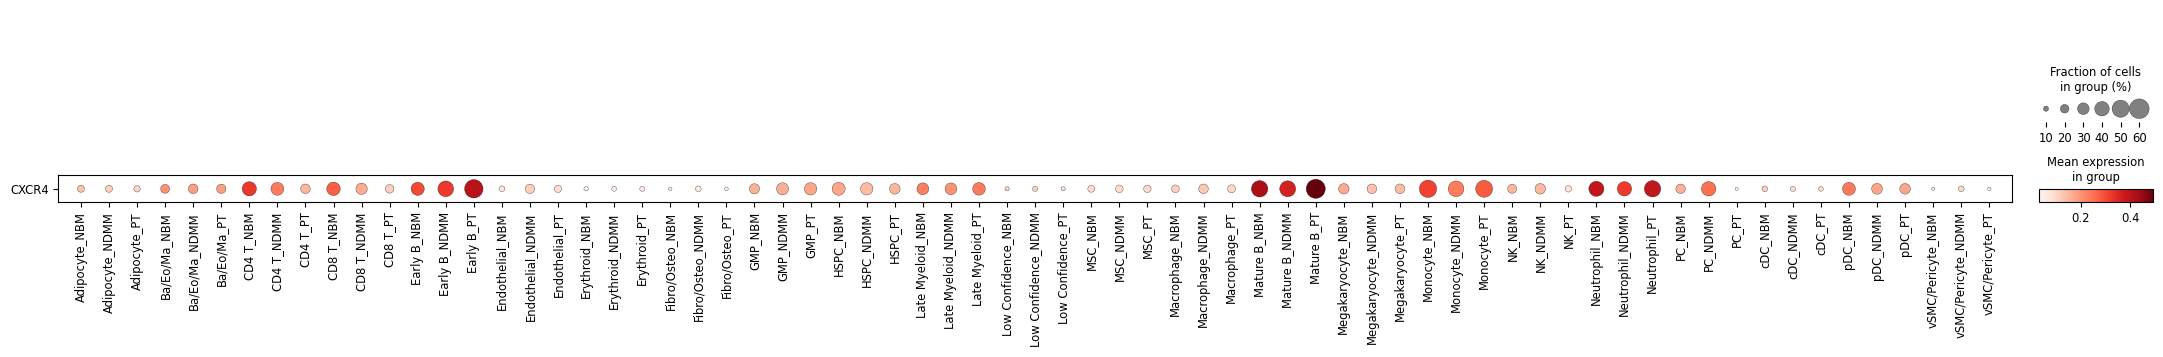

In [146]:
sc.pl.dotplot(ird_xenium_merge, var_names = ['CXCR4'], groupby = 'annot_timepoint', swap_axes = True)

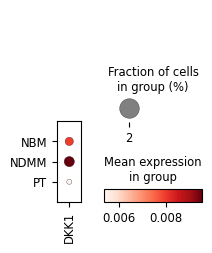

In [104]:
sc.pl.dotplot(ird_msc_PC_filtered, var_names = ['DKK1'], groupby = 'Collection', dot_max = .02)

### Distance between MSCs and B/Plasma cells

In [18]:
msc_df = ird_msc.obs[['Sample', 'x_centroid', 'y_centroid']].copy()
b_df = ird_xenium_merge.obs[ird_xenium_merge.obs['ct'] == 'Mature B'][['Sample', 'x_centroid', 'y_centroid']].copy()
earlyB_df = ird_xenium_merge.obs[ird_xenium_merge.obs['ct'] == 'Early B'][['Sample', 'x_centroid', 'y_centroid']].copy()
PC_df = ird_xenium_merge.obs[ird_xenium_merge.obs['ct'] == 'PC'][['Sample', 'x_centroid', 'y_centroid']].copy()
msc_B_dist = spatial_utils.nearest_dist_between_two_celltypes(msc_df, b_df, sample_col = 'Sample', x_col='x_centroid', y_col='y_centroid')
msc_earlyB_dist = spatial_utils.nearest_dist_between_two_celltypes(msc_df, earlyB_df, sample_col = 'Sample', x_col='x_centroid', y_col='y_centroid')
msc_PC_dist = spatial_utils.nearest_dist_between_two_celltypes(msc_df, PC_df, sample_col = 'Sample', x_col='x_centroid', y_col='y_centroid')
msc_B_dist['ref_ct'] = 'B cell'
msc_earlyB_dist['ref_ct'] = 'Early B'
msc_PC_dist['ref_ct'] = 'Plasma cell'
msc_dists = pd.concat([msc_B_dist, msc_earlyB_dist, msc_PC_dist], axis = 0)
msc_dists.head()

,Sample,x_centroid,y_centroid,nearest_dist_to_df2,ref_ct
0,IRD_S18-30740A1U3,2636.337646,1802.513306,31.762175,B cell
1,IRD_S18-30740A1U3,2715.739746,1886.723022,91.186961,B cell
2,IRD_S18-30740A1U3,3531.168701,2991.858154,30.770575,B cell
3,IRD_S18-30740A1U3,3522.896484,2811.001221,72.330735,B cell
4,IRD_S18-30740A1U3,3544.046143,2703.578369,47.931331,B cell


In [19]:
from scipy.stats import gaussian_kde

res = []
for sample in msc_dists['Sample'].unique():
    sample_df = msc_dists[msc_dists['Sample'] == sample]
    for ref_ct in sample_df['ref_ct'].unique():
        sample_ref_df = sample_df[sample_df['ref_ct'] == ref_ct]
        if len(sample_ref_df) < 10:
            continue
        # Estimate distance using KDE
        kde = gaussian_kde(sample_ref_df['nearest_dist_to_df2'])
        dist_eval = np.arange(0, 501, 1)
        kde_pdf = kde.pdf(dist_eval)
        most_likely_dist = dist_eval[np.argmax(kde_pdf)]
        res.append({
            'Sample': sample,
            'Reference Cell Type': ref_ct,
            'Most Likely Distance': most_likely_dist,
            'Average Distance': sample_ref_df['nearest_dist_to_df2'].mean(),
            'Median Distance': sample_ref_df['nearest_dist_to_df2'].median()
        })

most_likely_dists_df = pd.DataFrame(res)


In [60]:
most_likely_dists_df

,Sample,Reference Cell Type,Most Likely Distance,Average Distance,Median Distance
0,IRD_S18-30740A1U3,B cell,24,55.739195,42.503291
1,IRD_S18-30740A1U3,Early B,44,84.695446,67.030628
2,IRD_S18-30740A1U3,Plasma cell,7,10.425595,7.939184
3,S11-3564A1U1,B cell,33,67.682354,35.944905
4,S11-3564A1U1,Early B,57,112.175017,71.410555
...,...,...,...,...,...
199,SP130U1-A1-S1Fp1U1Q1,Early B,28,60.332284,44.929221
200,SP130U1-A1-S1Fp1U1Q1,Plasma cell,20,50.738183,41.176889
201,SP130U1-A1-S1Fp1U1Q2,B cell,20,32.723998,24.578430
202,SP130U1-A1-S1Fp1U1Q2,Early B,33,61.116558,42.057873


In [20]:
collection_meta = ird_xenium_merge.obs[['Sample', 'Collection']].drop_duplicates().set_index('Sample')
most_likely_dists_df['Collection'] = most_likely_dists_df['Sample'].map(collection_meta['Collection'])

/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/utils/plot_utils.py:153: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  # Step 3: Draw significance bars, avoiding overlap


(<Figure size 600x500 with 1 Axes>,
   Condition 1 Condition 2        Group  U statistic       p-value  \
 0        NDMM          PT       B cell        304.0  1.670464e-02   
 1        NDMM         NBM       B cell        575.0  4.224808e-04   
 2          PT         NBM       B cell        145.5  9.079404e-01   
 3        NDMM          PT      Early B        334.5  1.597258e-03   
 4        NDMM         NBM      Early B        521.0  9.240829e-03   
 5          PT         NBM      Early B        103.0  1.293778e-01   
 6        NDMM          PT  Plasma cell          3.0  2.516195e-07   
 7        NDMM         NBM  Plasma cell         56.5  9.767072e-08   
 8          PT         NBM  Plasma cell        258.0  3.657924e-04   
 
           p_adj    Sig  
 0  2.147739e-02   True  
 1  9.505818e-04   True  
 2  9.079404e-01  False  
 3  2.875065e-03   True  
 4  1.386124e-02   True  
 5  1.455500e-01  False  
 6  1.132288e-06   True  
 7  8.790365e-07   True  
 8  9.505818e-04   True  )

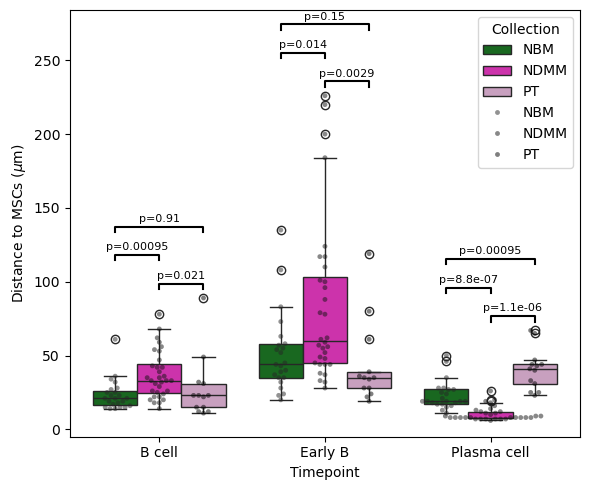

In [22]:
plot_utils.plot_multigroup_boxplot_with_significance(most_likely_dists_df, x_col = 'Reference Cell Type', y_col = 'Most Likely Distance', hue_col = 'Collection', 
                                                    order=None, hue_order=None, show_swarm=True, palette=timecols, figsize=(6, 5), xlabel='Timepoint', ylabel=r'Distance to MSCs ($\mu$m)', 
                                                    title=None, save_path='/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_MSC_PCB_distance.pdf')

## Section 5: Spatial Neighbor Cell Type Composition

Analyze the cellular neighborhood (nearest neighbors) composition around each cell type using spatial proximity. This approach identifies which cell types preferentially localize near each other, revealing potential cellular interactions and microenvironmental niches.

### Nearest neighbor identification: Delaunay + KDTree hybrid approach

The neighbor detection combines two complementary methods:
1. **Delaunay triangulation**: Identifies neighbors based on spatial tessellation
2. **Distance threshold (KDTree)**: Filters neighbors by maximum distance, removing distant connections from the triangulation

Only cells that satisfy **both** criteria (Delaunay neighbors within distance threshold) are retained as true spatial neighbors. This hybrid approach avoids spurious long-range connections while maintaining biologically relevant local neighborhoods.

In [26]:
from scipy.spatial import Delaunay, KDTree
def get_proximal_neighbors(df, x_col='x_centroid', y_col='y_centroid', distance_threshold=50):
    """
    Identify proximal spatial neighbors using Delaunay triangulation intersected with distance threshold.
    
    This hybrid approach combines:
    1. Delaunay triangulation to find neighbors
    2. KDTree radius search to enforce distance constraints
    
    Only cells that are BOTH Delaunay neighbors AND within the distance threshold are retained,
    ensuring biologically relevant local neighborhoods without spurious long-range connections.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing cell coordinates with an index that will be preserved
    x_col : str
        Column name for x-coordinates (default: 'x_centroid')
    y_col : str  
        Column name for y-coordinates (default: 'y_centroid')
    distance_threshold : float
        Maximum distance (in same units as coordinates) for considering cells as neighbors.
        Typical values: 20-50 microns for Xenium data

    Returns:
    --------
    dict
        Dictionary mapping each cell index to a list of neighbor cell indices.
        Keys and values are original DataFrame indices.
        
    Example:
    --------
    # Get neighbors within 25 microns for a sample
    sample_data = cell_info[cell_info['Sample'] == 'Sample1']
    neighbors = get_proximal_neighbors(sample_data, distance_threshold=25)
    
    # Access neighbors of first cell
    first_cell_idx = sample_data.index[0]
    first_cell_neighbors = neighbors[first_cell_idx]
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    if x_col not in df.columns:
        raise ValueError(f"Column '{x_col}' not found in DataFrame.")
    if y_col not in df.columns:
        raise ValueError(f"Column '{y_col}' not found in DataFrame.")

    points = df[[x_col, y_col]].values
    original_indices_map = df.index # To map points array indices back to original df indices

    
    if len(points) < 3:
        # Delaunay triangulation requires at least 3 points to form a simplex (triangle in 2D).
        print("Not enough points to perform Delaunay triangulation. Need at least 3 points.")
        return {idx: [] for idx in df.index} # Return mapping to original DataFrame indices
        
    tri = Delaunay(points)

    # tri.vertex_neighbor_vertices is a CSR-like structure:
    # indptr[i] to indptr[i+1] gives the slice in 'indices' for the i-th point in the 'points' array
    # indices[indptr[i]:indptr[i+1]] gives the actual indices (referring to the 'points' array)
    # of the neighbors for the i-th point.
    indptr, delaunay_indices = tri.vertex_neighbor_vertices
    kdtree = KDTree(points)

    proximal_neighbors = {}
    for i in range(len(points)):
        current_original_idx = original_indices_map[i]
        
        # a. Get Delaunay neighbors (indices relative to 'points' array)
        delaunay_neighbors_for_i = delaunay_indices[indptr[i]:indptr[i+1]]
        delaunay_set = set(delaunay_neighbors_for_i)
        
        # b. Get K-D tree neighbors (indices relative to 'points' array)
        # query_ball_point returns a list of indices of points within the radius
        kdtree_neighbors_for_i = kdtree.query_ball_point(points[i], r=distance_threshold)
        # Remove the point itself from its k-d tree neighbors
        kdtree_set = set(kdtree_neighbors_for_i) - {i} 
        
        # c. Intersect the two sets
        intersected_neighbor_indices_in_points_array = list(delaunay_set.intersection(kdtree_set))
        
        # d. Map intersected indices back to original DataFrame indices
        final_neighbor_original_indices = [original_indices_map[n_idx] for n_idx in intersected_neighbor_indices_in_points_array]
        
        proximal_neighbors[current_original_idx] = final_neighbor_original_indices
        
    return proximal_neighbors


In [3]:
ird_xenium_merge = sc.read_h5ad("/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/merged_filtered.h5ad")

In [4]:
ird_xenium_merge

AnnData object with n_obs × n_vars = 3413171 × 513
    obs: 'x_centroid', 'y_centroid', 'cell_area', 'nucleus_area', 'Sample', 'UPN', 'DI_UPN', 'DI_Sample', 'Collection', 'Panel', 'MRD.Status', 'Months_PFS', 'nCounts', 'annot', 'Original_Barcode'
    uns: 'annot_colors', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'norm_log'

In [102]:
ird_cell_info = ird_xenium_merge.obs.copy()
ird_cell_info.head()

,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,DI_Sample,Collection,Panel,MRD.Status,Months_PFS,nCounts,annot,Original_Barcode
IRD_S18-30740A1U3_aaaefkpp-1,433.430206,1357.545288,37.660314,23.932813,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,136.0,Erythro.,aaaefkpp-1
IRD_S18-30740A1U3_aaaekejm-1,449.853851,1278.230225,31.067501,20.817032,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,115.0,Granulo.,aaaekejm-1
IRD_S18-30740A1U3_aaaekekb-1,438.366547,1361.509277,46.240002,17.340001,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,137.0,Erythro.,aaaekekb-1
IRD_S18-30740A1U3_aaaeonma-1,438.007660,1311.078979,125.715005,59.380471,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,291.0,Erythro.,aaaeonma-1
IRD_S18-30740A1U3_aaaflkno-1,373.216797,1557.585327,46.194845,30.480470,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,88.0,Erythro.,aaaflkno-1


In [16]:
ird_cell_info['annot'].unique().tolist()

['Erythro.',
 'Granulo.',
 'PC',
 'Mc/Mp',
 'T',
 'B',
 'Adipo.',
 'NK',
 'Fibro./Osteo.',
 'MSC',
 'Endo.',
 'pDC',
 'cDC',
 'HSPC']

In [19]:
ird_cell_info['Collection'].unique().tolist()

['NDMM', 'PT', 'NBM']

In [ ]:
from collections import Counter
def neighboring_celltype_counts(cell_info, ct_col_name, ct_of_interest, neighbors_dict):
    """
    Count the cell type composition of neighbors around a specific cell type.
    
    For all cells of a given type, aggregates their neighbors' cell types to understand
    the composition around that cell type.
    
    Parameters:
    -----------
    cell_info : pd.DataFrame
        DataFrame with cell metadata including cell type annotations
    ct_col_name : str
        Column name containing cell type annotations (e.g., 'annot', 'group')
    ct_of_interest : str
        Specific cell type to analyze (e.g., 'PC', 'MSC', 'T')
    neighbors_dict : dict
        Output from get_proximal_neighbors() function mapping cell indices to neighbor indices
        
    Returns:
    --------
    dict
        Dictionary mapping each cell type to the count of how many times it appears
        as a neighbor of the cell type of interest. All cell types in the dataset
        are included (with 0 for types that never appear as neighbors).
        
    Example output:
    ---------------
    {'PC': 1250, 'MSC': 450, 'T': 890, 'B': 120, ...}
    # Interpretation: Plasma cells (PC) have 1250 plasma cell neighbors total,
    # 450 MSC neighbors, 890 T cell neighbors, etc.
    
    Example usage:
    --------------
    # Count what cell types are around plasma cells in a sample
    neighbors = get_proximal_neighbors(sample_data)
    pc_neighborhood = neighboring_celltype_counts(
        sample_data, 
        ct_col_name='annot',
        ct_of_interest='PC',
        neighbors_dict=neighbors
    )
    """
    ct_index = cell_info[cell_info[ct_col_name] == ct_of_interest].index.values
    ct_neighbor_indices = [neighbors_dict[i] for i in ct_index]
    ct_neighbor_indices_flat = [item for sublist in ct_neighbor_indices for item in sublist]
    ct_neighbors = [cell_info[ct_col_name][i] for i in ct_neighbor_indices_flat]
    ct_neighbors_counter = Counter(ct_neighbors)
    
    # Get all unique cell types
    all_cell_types = np.unique(cell_info[ct_col_name])
    # Create dictionary with zeros for all cell types, then update with actual counts
    ct_neighbors_counts = {ct: 0 for ct in all_cell_types}
    ct_neighbors_counts.update(ct_neighbors_counter)

    return ct_neighbors_counts

In [17]:
test = ird_cell_info[ird_cell_info['Sample'] == 'IRD_S18-30740A1U3']
all_nbs = get_proximal_neighbors(test, x_col='x_centroid', y_col='y_centroid', distance_threshold=25)
nb_ct = neighboring_celltype_counts(test, 'annot', 'PC', all_nbs)
nb_ct

{'Adipo.': 334,
 'B': 1408,
 'Endo.': 2705,
 'Erythro.': 16334,
 'Fibro./Osteo.': 233,
 'Granulo.': 16562,
 'HSPC': 12,
 'MSC': 5692,
 'Mc/Mp': 3054,
 'NK': 254,
 'PC': 108114,
 'T': 1600,
 'cDC': 94,
 'pDC': 51}

In [ ]:
def run_neighboring_celltype_analysis(df, ct_col, sample_col, distance_threshold=25, x_col='x_centroid', y_col='y_centroid'):
    """
    Calculates neighbor composition across all cell types and samples. Calls neighboring_celltype_counts().

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with cell metadata including coordinates, cell types, and sample IDs
    ct_col : str
        Column name for cell type annotations
    sample_col : str
        Column name for sample identifiers
    distance_threshold : float
        Maximum distance (microns) for neighbor consideration (default: 25)
    x_col : str
        Column name for x-coordinates (default: 'x_centroid')
    y_col : str
        Column name for y-coordinates (default: 'y_centroid')
        
    Returns:
        pd.DataFrame: DataFrame with columns for cell type, neighboring cell type, sample ID, and counts of neighboring cell types.
    """

    # Initialize an empty DataFrame to store results
    all_nb_df = pd.DataFrame()

    # Loop through each sample
    for sample in df[sample_col].unique().tolist():
        sample_df = df[df[sample_col] == sample]
        # Get proximal neighbor dict for all cells
        all_neighbors = get_proximal_neighbors(sample_df, x_col=x_col, y_col=y_col, distance_threshold=distance_threshold)

        for ct in sample_df[ct_col].unique().tolist():       
            # Count neighboring cell types of all cell types
            nb_counts = neighboring_celltype_counts(sample_df, ct_col, ct, all_neighbors)
            nb_df = pd.DataFrame.from_dict(nb_counts, orient = "index", columns = ["counts"])
            nb_df['Cell Type'] = ct
            nb_df['Neighboring Cell Type'] = nb_df.index
            nb_df['Sample'] = sample
            nb_df.reset_index(drop = True, inplace = True)
            all_nb_df = pd.concat([all_nb_df, nb_df], axis = 0)
            
        print(f"Finished processing sample {sample}")
    
    return all_nb_df


all_nb_df = run_neighboring_celltype_analysis(ird_cell_info, 'annot', 'Sample', distance_threshold = 25, x_col='x_centroid', y_col='y_centroid')

Finished processing sample IRD_S18-30740A1U3
Finished processing sample S11-3564A1U1
Finished processing sample S13-35096A1U1
Finished processing sample S13-47674A1U1
Finished processing sample S14-11561A1U1
Finished processing sample S14-14053A1U1
Finished processing sample S14-14053A1U2
Finished processing sample S14-18864-A1U1
Finished processing sample S14-22950-A1U1
Finished processing sample S14-9876A1U1
Finished processing sample S15-15758-A1U1
Finished processing sample S16-26183A1U1
Finished processing sample S16-30080A1U1
Finished processing sample S17-24784A1U1
Finished processing sample S17-24784A1U2
Finished processing sample S17-32736-A1U1
Finished processing sample S17-34578-A1U1
Finished processing sample S17-5570A1U1
Finished processing sample S18-36373A1U1
Finished processing sample S18-461-A1U1
Finished processing sample S18-6148A1U1
Finished processing sample S19-25371-A1U1
Finished processing sample S20-2375-A1U1
Finished processing sample S21-1209-A1U1
Finished pr

### Scaled neighboring cell type composition heatmap

In [105]:
all_nb_df.to_csv("/diskmnt/Users2/chouw/Projects/BM_spatial/IRD_Xenium_merge_neighboringCelltype_counts.csv")

In [106]:
# Find sample ID whose collection is NBM
nbm_samples = ird_cell_info[ird_cell_info['Collection'] == 'NBM']['Sample'].unique().tolist()
ndmm_samples = ird_cell_info[ird_cell_info['Collection'] == 'NDMM']['Sample'].unique().tolist()
pt_samples = ird_cell_info[ird_cell_info['Collection'] == 'PT']['Sample'].unique().tolist()

In [107]:
# Calculate z score for each neighboring cell type across cell types within each sample
all_nb_df['pct'] = all_nb_df['counts'] / all_nb_df.groupby(['Sample', 'Cell Type'])['counts'].transform('sum') * 100
all_nb_df['zscore_nct'] = all_nb_df.groupby(['Sample', 'Neighboring Cell Type'])['pct'].transform(lambda x: (x - x.mean()) / x.std())

In [108]:
nbm_nb_df = all_nb_df[all_nb_df['Sample'].isin(nbm_samples)]
ndmm_nb_df = all_nb_df[all_nb_df['Sample'].isin(ndmm_samples)]
pt_nb_df = all_nb_df[all_nb_df['Sample'].isin(pt_samples)]



In [109]:
# Calculate mean and std of pct for each cell type and neighboring cell type, within each sample, grouped by disease
summary_nbm_df = nbm_nb_df.groupby(['Cell Type', 'Neighboring Cell Type']).agg(
    mean_zscore_nct=('zscore_nct', 'mean')
).reset_index()
summary_nbm_df

,Cell Type,Neighboring Cell Type,mean_zscore_nct
0,Adipo.,Adipo.,3.365812
1,Adipo.,B,-0.273847
2,Adipo.,Endo.,0.078409
3,Adipo.,Erythro.,-0.473036
4,Adipo.,Fibro./Osteo.,-0.189942
...,...,...,...
284,pDC,PC,-0.386275
285,pDC,T,1.151485
286,pDC,Unknown,0.103905
287,pDC,cDC,0.404247


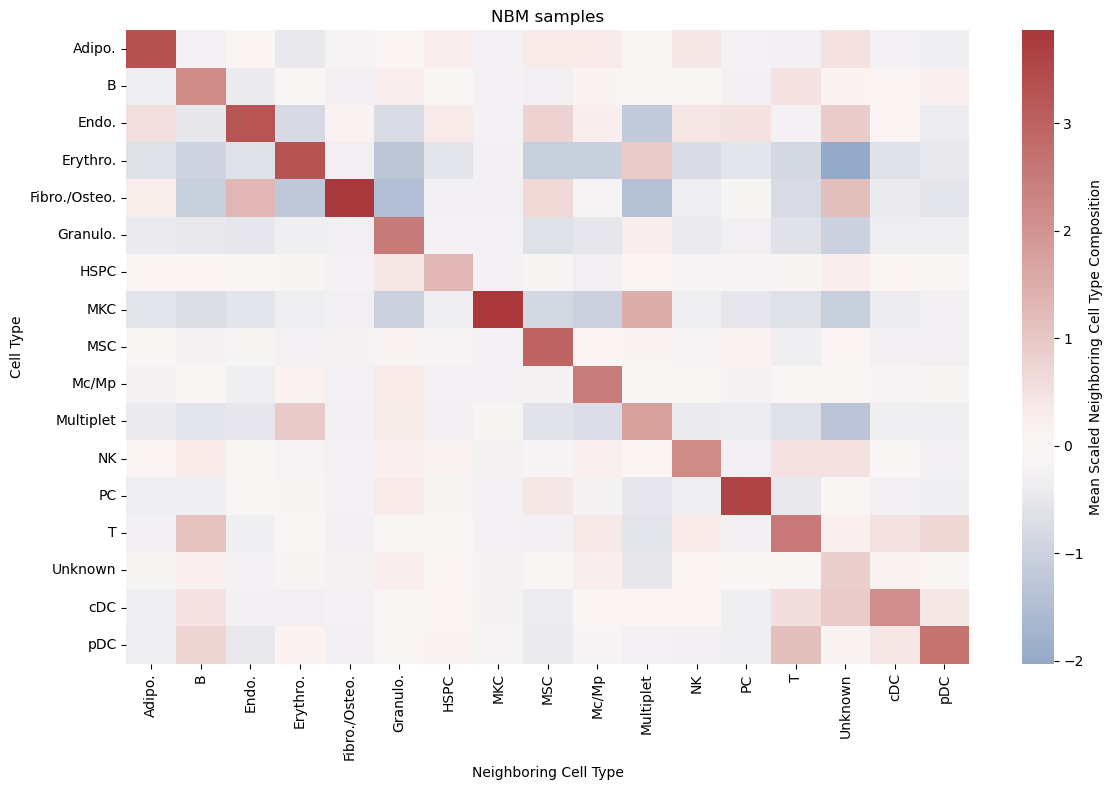

In [110]:
summary_nbm_df['mean_pct_scaled'] = summary_nbm_df.groupby('Neighboring Cell Type')['mean_zscore_nct'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)
# Draw heatmap of scaled mean pct
plt.figure(figsize = (12, 8))
heatmap_data = summary_nbm_df.pivot(index = 'Cell Type', columns = 'Neighboring Cell Type', values = 'mean_zscore_nct')
sns.heatmap(heatmap_data, cmap = 'vlag', center = 0, cbar_kws={'label': 'Mean Scaled Neighboring Cell Type Composition'})
plt.title("NBM samples")
plt.tight_layout()
#plt.savefig("/diskmnt/Users2/chouw/Projects/BM_spatial/NBM_MM_Xenium_merge_WC_neighboringCelltype_composition_healthy_samples_heatmap_v09192025.pdf", dpi = 300, transparent = True)

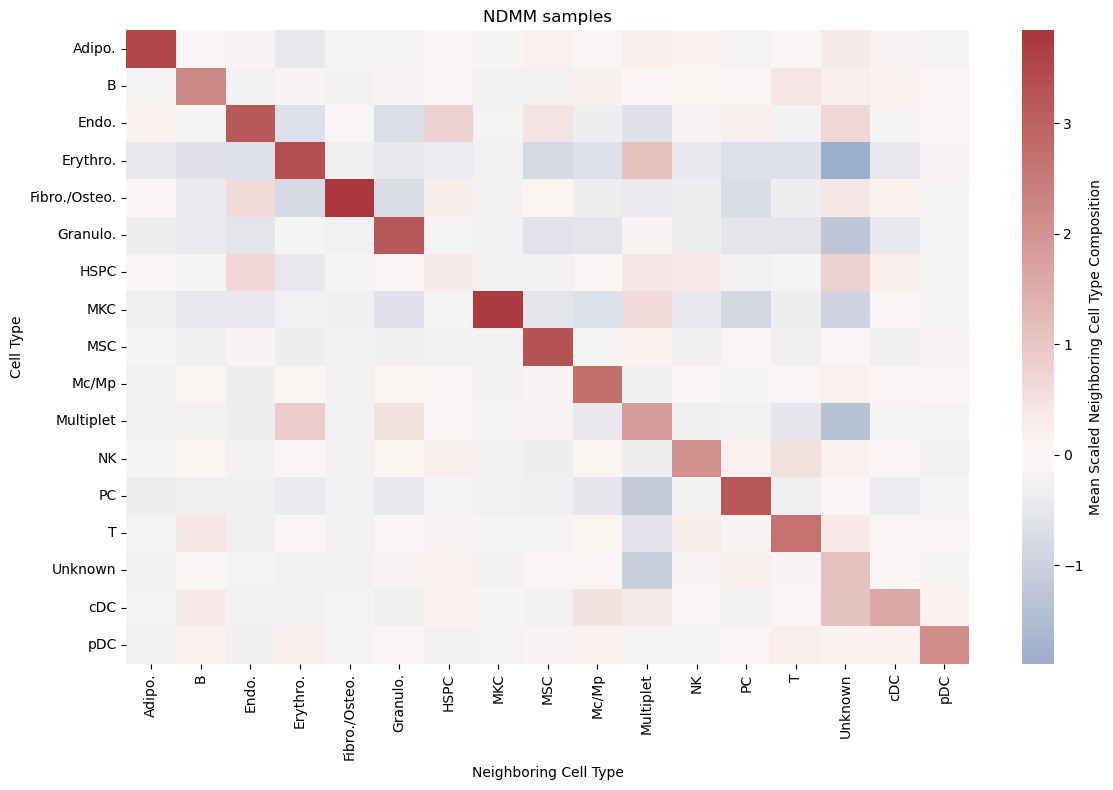

In [111]:
summary_ndmm_df = ndmm_nb_df.groupby(['Cell Type', 'Neighboring Cell Type']).agg(
    mean_zscore_nct=('zscore_nct', 'mean')
).reset_index()
summary_ndmm_df['mean_pct_scaled'] = summary_ndmm_df.groupby('Neighboring Cell Type')['mean_zscore_nct'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)
# Draw heatmap of scaled mean pct
plt.figure(figsize = (12, 8))
heatmap_data = summary_ndmm_df.pivot(index = 'Cell Type', columns = 'Neighboring Cell Type', values = 'mean_zscore_nct')
sns.heatmap(heatmap_data, cmap = 'vlag', center = 0, cbar_kws={'label': 'Mean Scaled Neighboring Cell Type Composition'})
plt.title("NDMM samples")
plt.tight_layout()

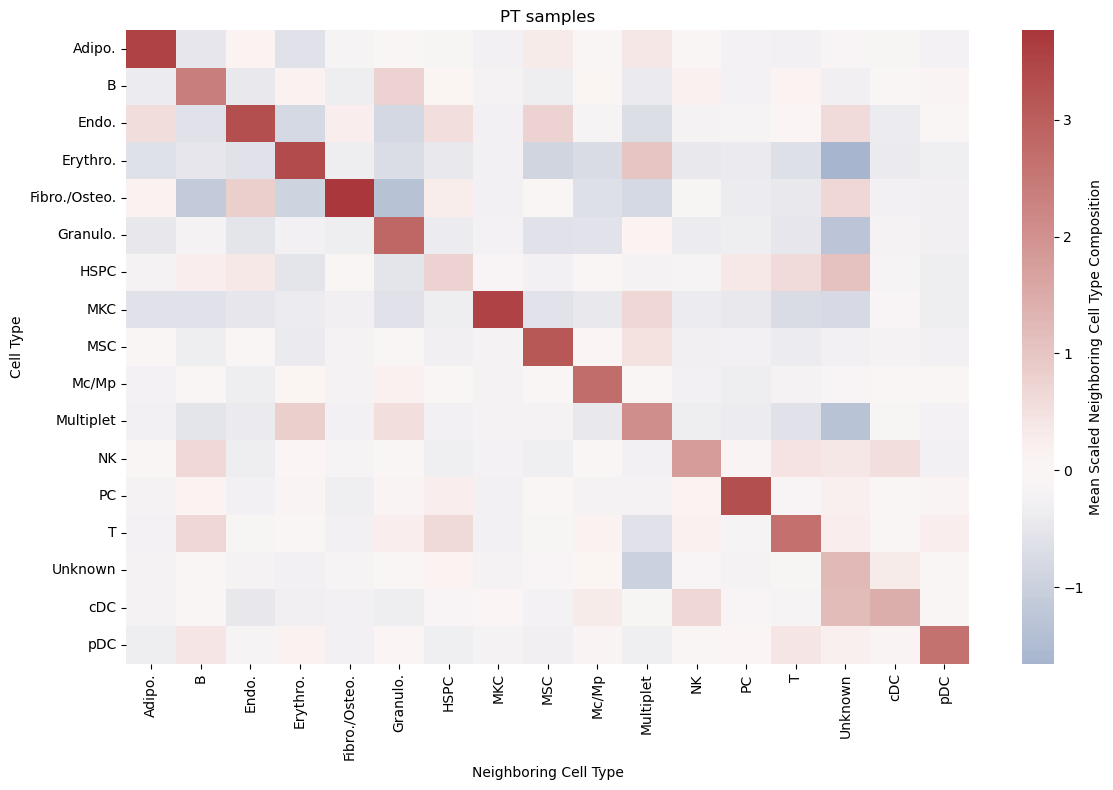

In [112]:
summary_pt_df = pt_nb_df.groupby(['Cell Type', 'Neighboring Cell Type']).agg(
    mean_zscore_nct=('zscore_nct', 'mean')
).reset_index()
summary_pt_df['mean_pct_scaled'] = summary_pt_df.groupby('Neighboring Cell Type')['mean_zscore_nct'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)
# Draw heatmap of scaled mean pct
plt.figure(figsize = (12, 8))
heatmap_data = summary_pt_df.pivot(index = 'Cell Type', columns = 'Neighboring Cell Type', values = 'mean_zscore_nct')
sns.heatmap(heatmap_data, cmap = 'vlag', center = 0, cbar_kws={'label': 'Mean Scaled Neighboring Cell Type Composition'})
plt.title("PT samples")
plt.tight_layout()